In [1]:
import math, glob, time, os, re, json
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

from katrain.core.base_katrain import KaTrainBase
from katrain.core.game import Game, KaTrainSGF
from katrain.core.engine import KataGoEngine

[INFO   ] [Logger      ] Record log in /home/sander/.kivy/logs/kivy_20-06-19_220.txt
[INFO   ] [Kivy        ] v2.0.0rc2, git-78fb93b, 20200429
[INFO   ] [Kivy        ] Installed at "/home/sander/anaconda3/lib/python3.7/site-packages/kivy/__init__.py"
[INFO   ] [Python      ] v3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
[INFO   ] [Python      ] Interpreter at "/home/sander/anaconda3/bin/python"


In [2]:
kt = KaTrainBase(force_package_config=True)

In [3]:
e_config = kt.config("engine")
e_config["max_visits"] = e_config["fast_visits"] = 1 # super quick - maybe inaccurate
e_config["threads"] = 72
e_config["_include_ownership"] = False
e_config["config"] = "./kata_config.cfg"
e_config

{'katago': '',
 'model': 'katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz',
 'config': './kata_config.cfg',
 'threads': 72,
 'max_visits': 1,
 'fast_visits': 1,
 'max_time': 3.0,
 'wide_root_noise': 0.0,
 '_enable_ownership': True,
 '_include_ownership': False}

In [4]:
engine = KataGoEngine(kt, e_config)

2020-06-19 14:42:19+0200: Analysis Engine starting...
2020-06-19 14:42:19+0200: KataGo v1.4.2+kt1.1 (minified)
2020-06-19 14:42:19+0200: nnRandSeed0 = 5838361655364367414
2020-06-19 14:42:19+0200: After dedups: nnModelFile0 = /home/sander/anaconda3/lib/python3.7/site-packages/katrain/models/g170e-b15c192-s1672170752-d466197061.bin.gz useFP16 auto useNHWC auto
2020-06-19 14:42:21+0200: Found OpenCL Platform 0: NVIDIA CUDA (NVIDIA Corporation) (OpenCL 1.2 CUDA 10.2.131)
2020-06-19 14:42:21+0200: Found 1 device(s) on platform 0 with type CPU or GPU or Accelerator
2020-06-19 14:42:21+0200: Found OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) (score 11000102)
2020-06-19 14:42:21+0200: Using OpenCL Device 0: GeForce GTX 1050 Ti with Max-Q Design (NVIDIA Corporation) OpenCL 1.2 CUDA
2020-06-19 14:42:21+0200: Loaded tuning parameters from: /home/sander/.katrain/opencltuning/tune6_gpuGeForceGTX1050TiwithMaxQDesign_x19_y19_c192_mv8.txt
2020-06-19 14:42:21+0200: Loade

In [5]:
PLAYERS={'W':'white','B':'black'}

def get_move_stats(game):
    game.redo(999)
    moves = game.current_node.nodes_from_root[1:]  # without root
    while not all(m.analysis_ready for m in moves):
        time.sleep(0.01)

    parent_policy_per_move = [move.parent.policy_ranking for move in moves]
    b_scoreloss = [move.points_lost for move in moves]
    
    
    num_legal_moves = [sum(pv >= 0 for pv,_ in policy_ranking) for policy_ranking in parent_policy_per_move]
    policy_stats = [
        [(move_num+1, num_mv, rank, value, policy_ranking[0][0], move.score, move.points_lost, PLAYERS[mv.player]) 
        for rank, (value, mv) in enumerate(policy_ranking) if mv == move.move][0]
        for move_num,(move, policy_ranking, num_mv) in enumerate(zip(moves, parent_policy_per_move, num_legal_moves))
    ]
    return policy_stats


def rank_to_kyu(r):
    return 30-r

def outlier_free_stats(data):
    sorteddata = sorted(data)
    lendata = len(data)
    selected = sorteddata[int(lendata*.2):int(lendata*.8)+1]
    return np.mean(selected)

def normalized_histogram(data, **args):
    weights = np.ones_like(data) / len(data)
    plt.hist(data, weights=weights, **args)

skipped = defaultdict(int)
skipped['board_size'] = defaultdict(int)
skipped['timeout_players'] = defaultdict(int)
def analyze_game(filename):
    global skipped
    sgf = KaTrainSGF.parse_file(filename)
    gamedata_str = re.search('Gamedata:(.*)SGF with review',sgf.properties['C'][0],re.DOTALL)[1]
    gamedata = json.loads(gamedata_str)
    outcome = gamedata['outcome']
    rank = {p:rank_to_kyu(gamedata['players'][p]['rank']) for p in ['white','black']}
    players = {p:gamedata['players'][p]['username'] for p in ['white','black']}
    ids = {p:gamedata['players'][p]['id'] for p in ['white','black']}
    bot_player = 'black' if 'katrain-' in players['black'] else 'white'
    non_bot_player = 'black' if bot_player=='white' else 'white'
    winner = 'black' if gamedata['winner']==ids['black'] else 'white'
    gameid = gamedata['game_id']
    if sgf.board_size!=(19,19):
        skipped['board_size'][sgf.board_size] += 1
        return

    if outcome == 'Cancellation':
        skipped['cancelled'] += 1
        return

    if outcome == 'Timeout': # often abusers
        skipped['timeout'] += 1
        skipped['timeout_players'][players[non_bot_player]] += 1 # find abusers
        return    
    
    if len(gamedata['moves']) < MIN_MOVES:
        skipped['min_moves'] += 1
        return


    if 'active_game' in gamedata and gamedata['active_game'][non_bot_player]['ratings']['overall']['deviation'] > MAX_DEVIATION:
        skipped['provisional'] += 1
        return

    try:
        game = Game(kt, engine, move_tree=sgf)
        move_analysis =  [ (gameid,*stats,non_bot_player) for stats in get_move_stats(game) ] 
    except Exception as e:
        print(f"Error in analyzing {filename}: {e}") # branching etc
        return

    return gameid, (filename, players[bot_player],rank[bot_player], players[non_bot_player],
            rank[non_bot_player],non_bot_player, winner,outcome,gamedata['ranked']), move_analysis

2020-06-19 14:42:21+0200: Analyzing up to 72 positions at at time in parallel
2020-06-19 14:42:21+0200: Started, ready to begin handling requests


In [6]:
analyze_games = False
MAX_DEVIATION = 175 # exclude players with a non-established rank
MIN_MOVES = 100 # exclude games with < this many moves

In [7]:
if analyze_games:
    from multiprocessing.pool import ThreadPool
    import threading
    
    games_data = pd.DataFrame(columns=['file','bot','bot_rank','user','user_rank','user_color','winner','outcome','ranked'])
    moves_data = []

    files = glob.glob("sgf_ogs/*.sgf")
    pbar = tqdm(total=len(files))
    lock = threading.Lock()

    def process_file(filename):
        result = analyze_game(filename)
        pbar.update(1)
        if result:
            gameid, gamedata_row, move_analysis = result
            with lock:
                games_data.loc[gameid] = gamedata_row
                moves_data.append(move_analysis)            
            
            
    pool = ThreadPool(8)
    pool.map(process_file, files)
    pbar.close()
    
    moves_data = pd.DataFrame( sum(moves_data,[]),    
        columns=['game_id','move','num_legal','policy_rank','policy_value','top_value',
                 'black_score','points_lost','move_color','user_color'])

    games_data.to_csv('games.csv.gz',compression='gzip')
    moves_data.to_csv('moves.csv.gz',compression='gzip')
    print(f"{games_data.shape[0]} games and {moves_data.shape[0]} moves analyzed.\nGames skipped: {dict(skipped)}")
else:
    moves_data = pd.read_csv('moves.csv.gz',index_col=0)
    games_data = pd.read_csv('games.csv.gz',index_col=0)
    print(f"Loaded {games_data.shape[0]} games and {moves_data.shape[0]} moves.")    

Loaded 2431 games and 665119 moves.


In [8]:
plt.rcParams.update({'font.size': 22})

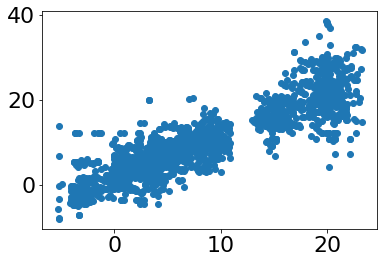

In [9]:
plt.scatter(games_data.bot_rank,games_data.user_rank)

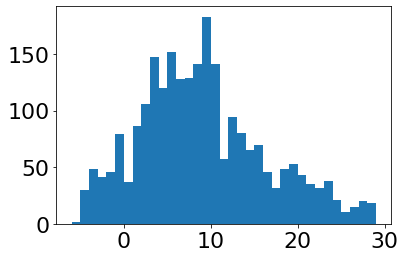

In [10]:
plt.hist(games_data.user_rank,bins=range(-6,30));

In [11]:
moves_data = moves_data.loc[moves_data.game_id.map(lambda x: x in games_data.index)] # race cond?

In [12]:
user_moves = moves_data[moves_data.move_color==moves_data.user_color].copy()
user_moves['rank'] = games_data.loc[user_moves.game_id].user_rank.values

bot_moves = moves_data[moves_data.move_color!=moves_data.user_color].copy()
bot_moves['rank'] = games_data.loc[bot_moves.game_id].bot_rank.values
labels = ['users','bots']

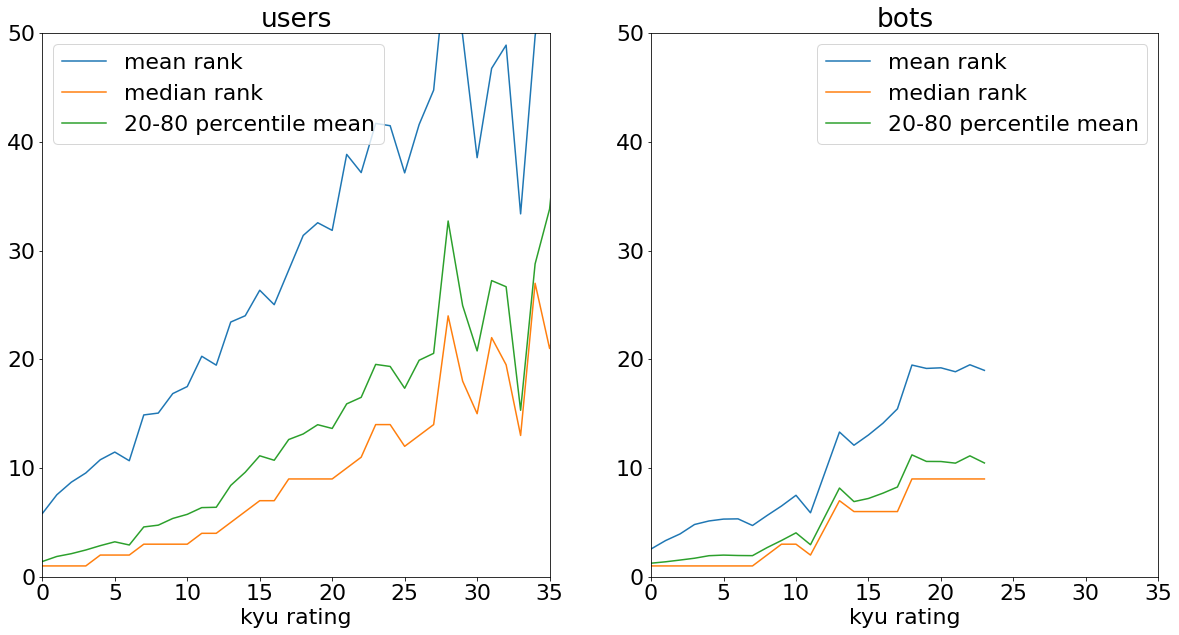

In [13]:
plt.figure(figsize=(20,10))
for i,moves in enumerate([user_moves,bot_moves]):
    stats = [(r,df.policy_rank.mean(),df.policy_rank.median(),outlier_free_stats(df.policy_rank.values),df.shape[0]) 
              for r,df in moves.groupby(moves['rank'].round())]    
    rank, mean, median, outlier_free_mean, sample_size = zip(*stats)
    plt.subplot(1,2,i+1)
    plt.plot(rank,mean,rank,median,rank,outlier_free_mean)
    plt.xlabel('kyu rating')
    plt.legend(['mean rank','median rank','20-80 percentile mean'])
    plt.title(labels[i])
    plt.ylim([0,50])
    plt.xlim([0,35])

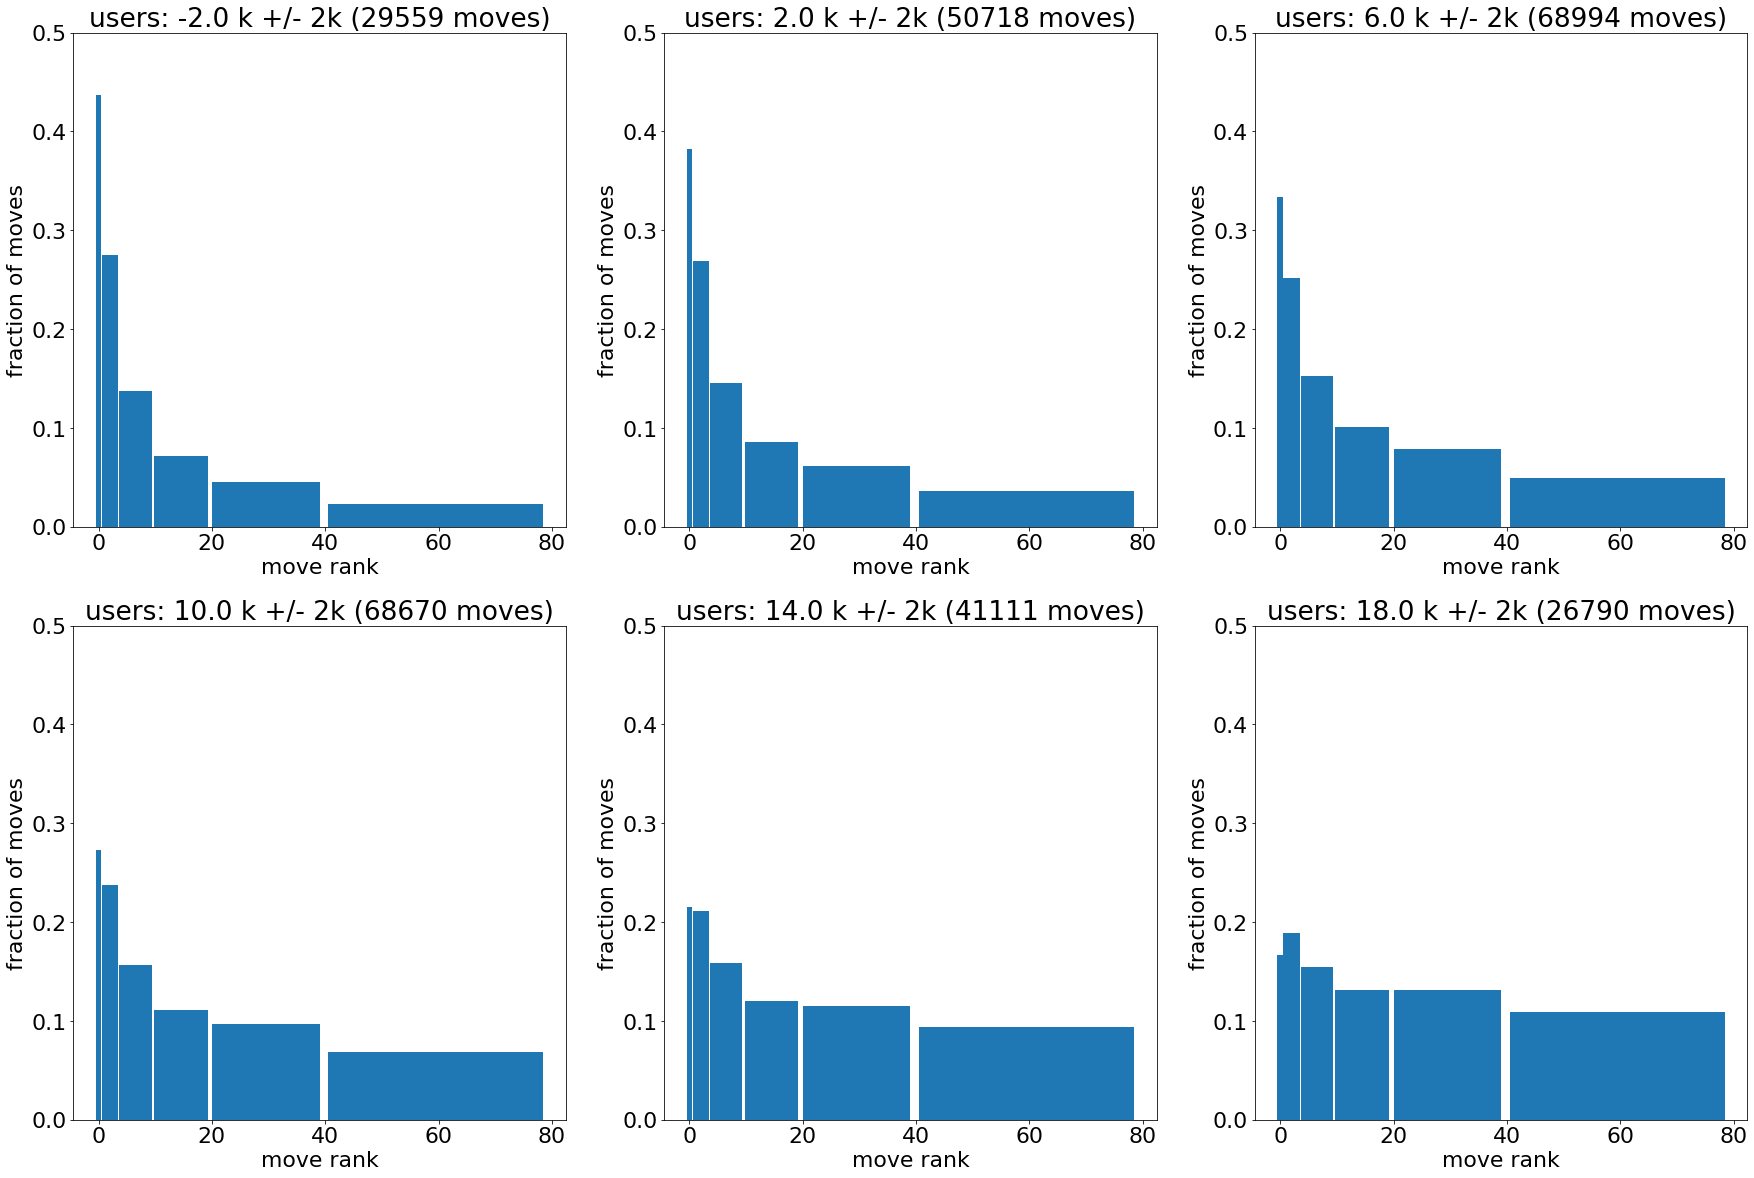

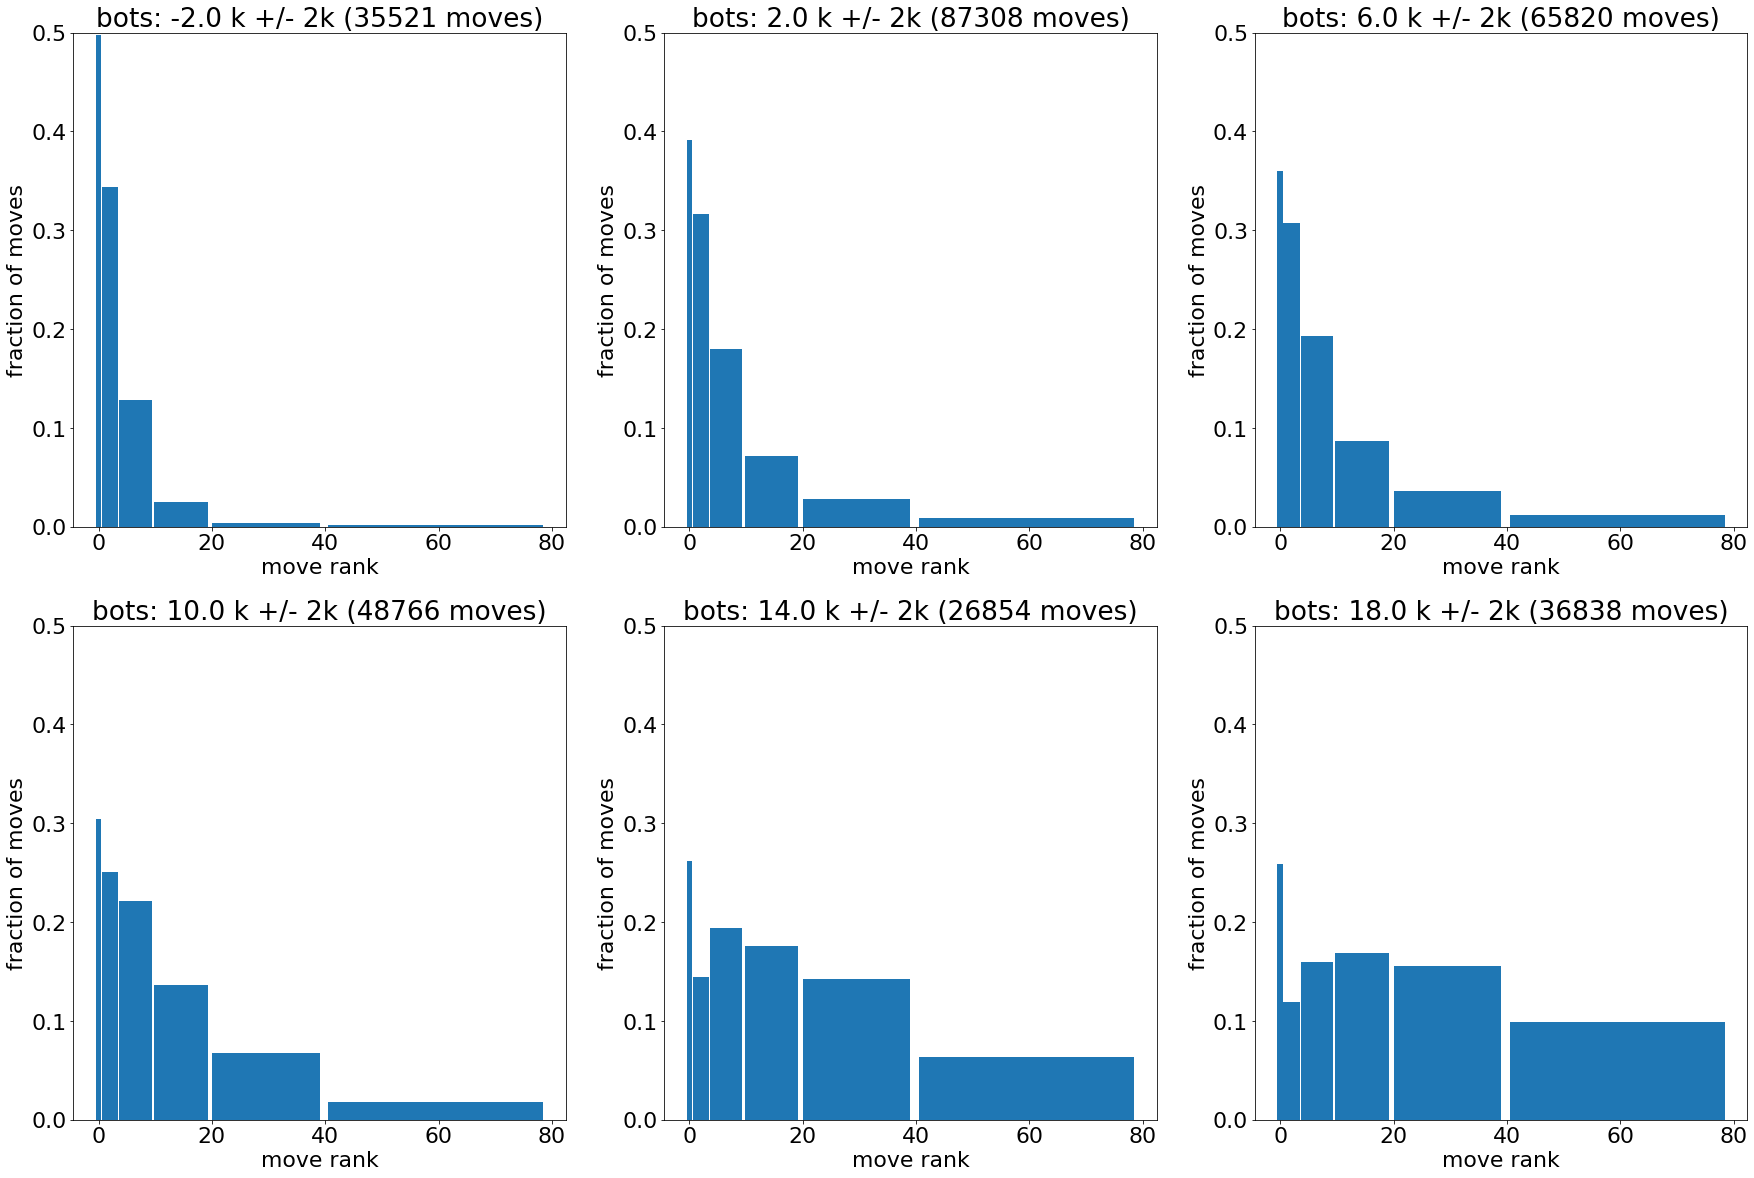

In [14]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.policy_rank.values,bins=[-0.5,0.5,3.5,9.5,19.5,39.5,79.5],rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('move rank')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

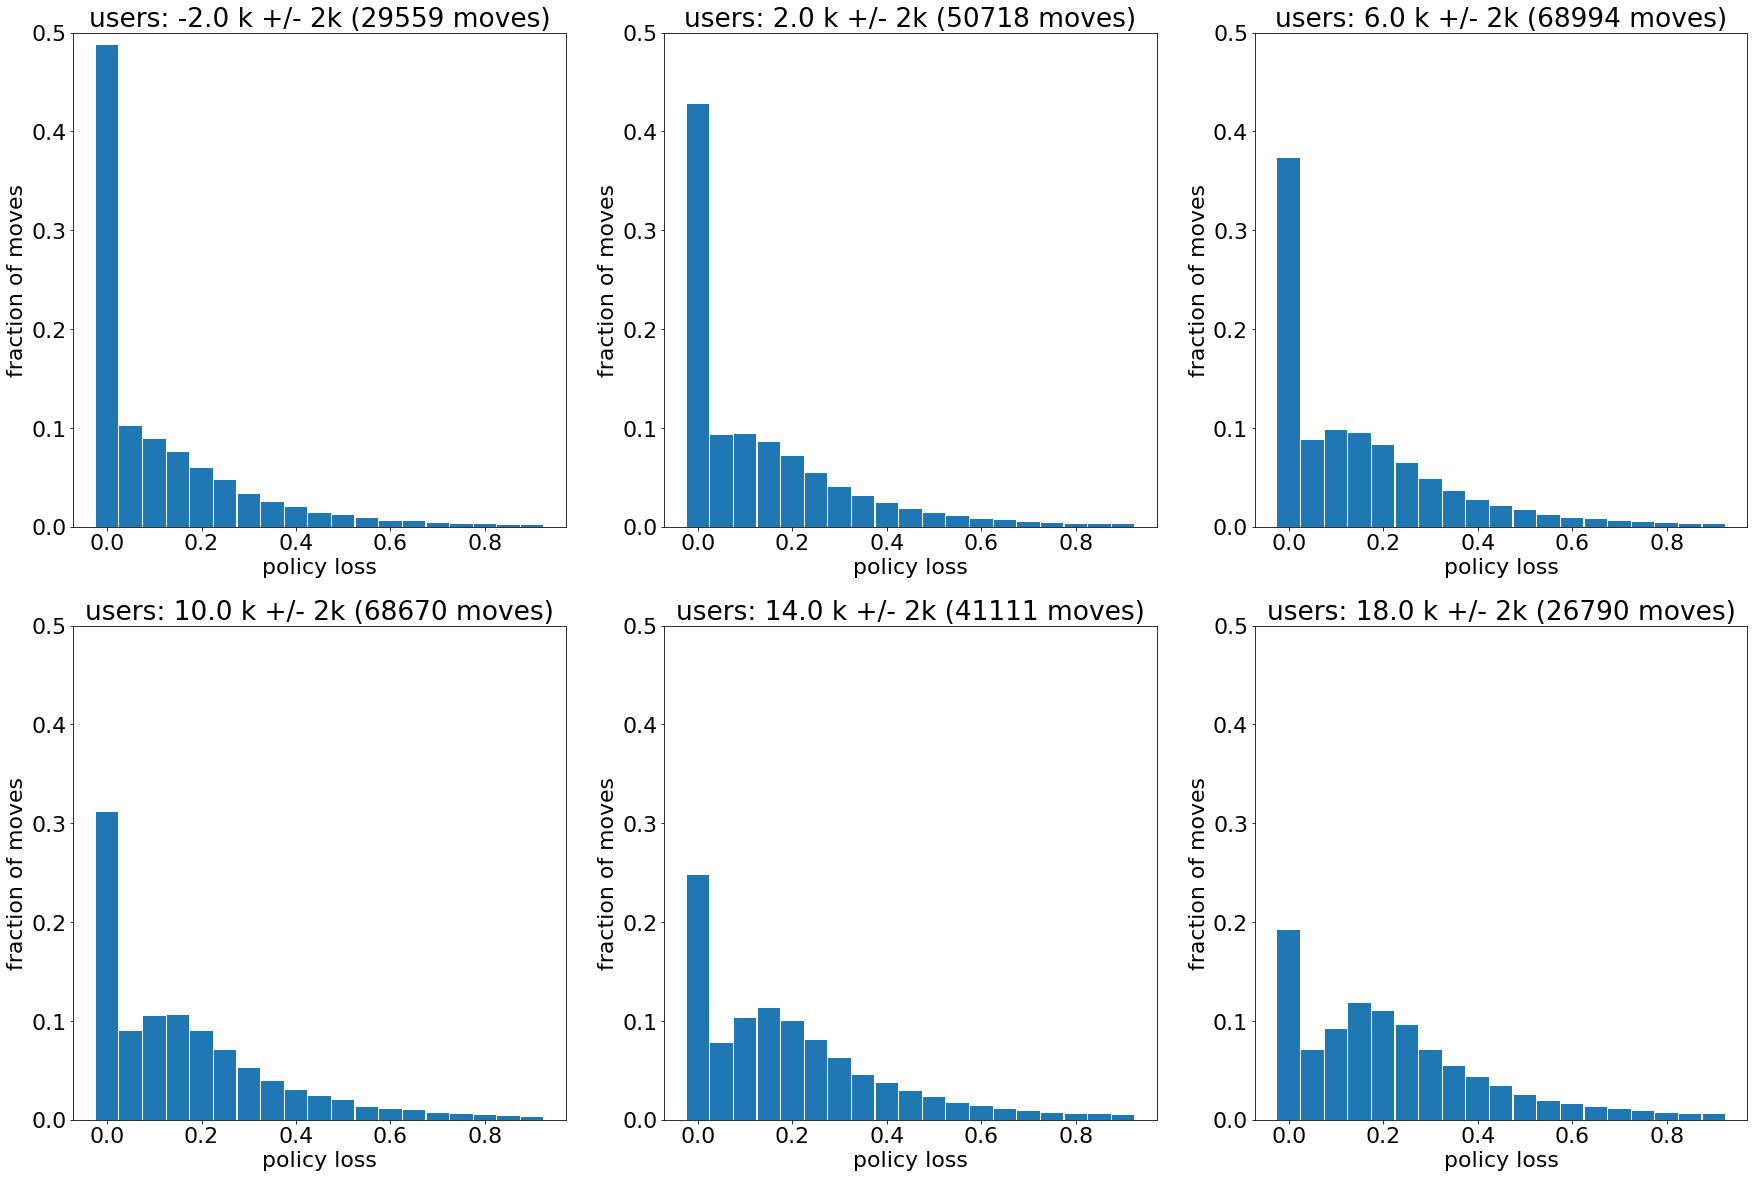

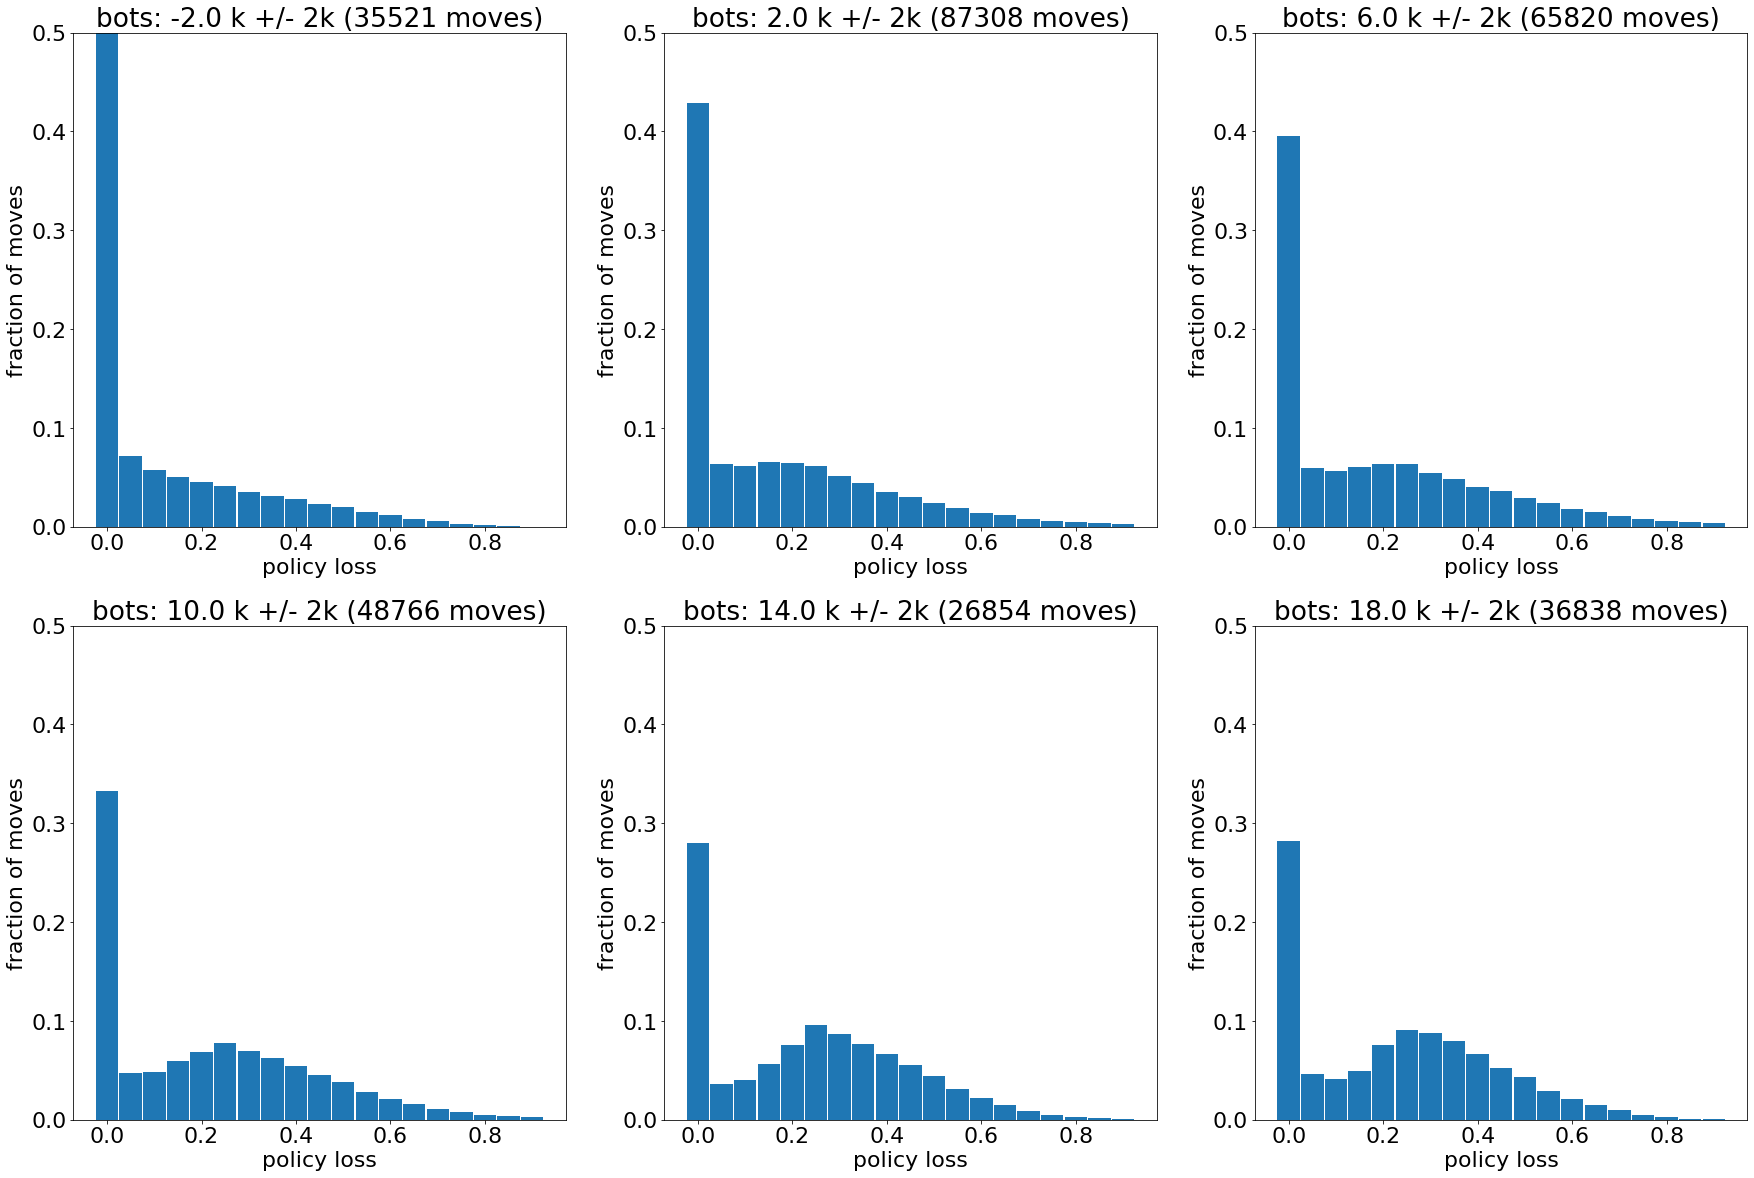

In [15]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.top_value - df.policy_value,bins=np.arange(-0.025,0.975,0.05),rwidth=0.95)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('policy loss')
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.5])

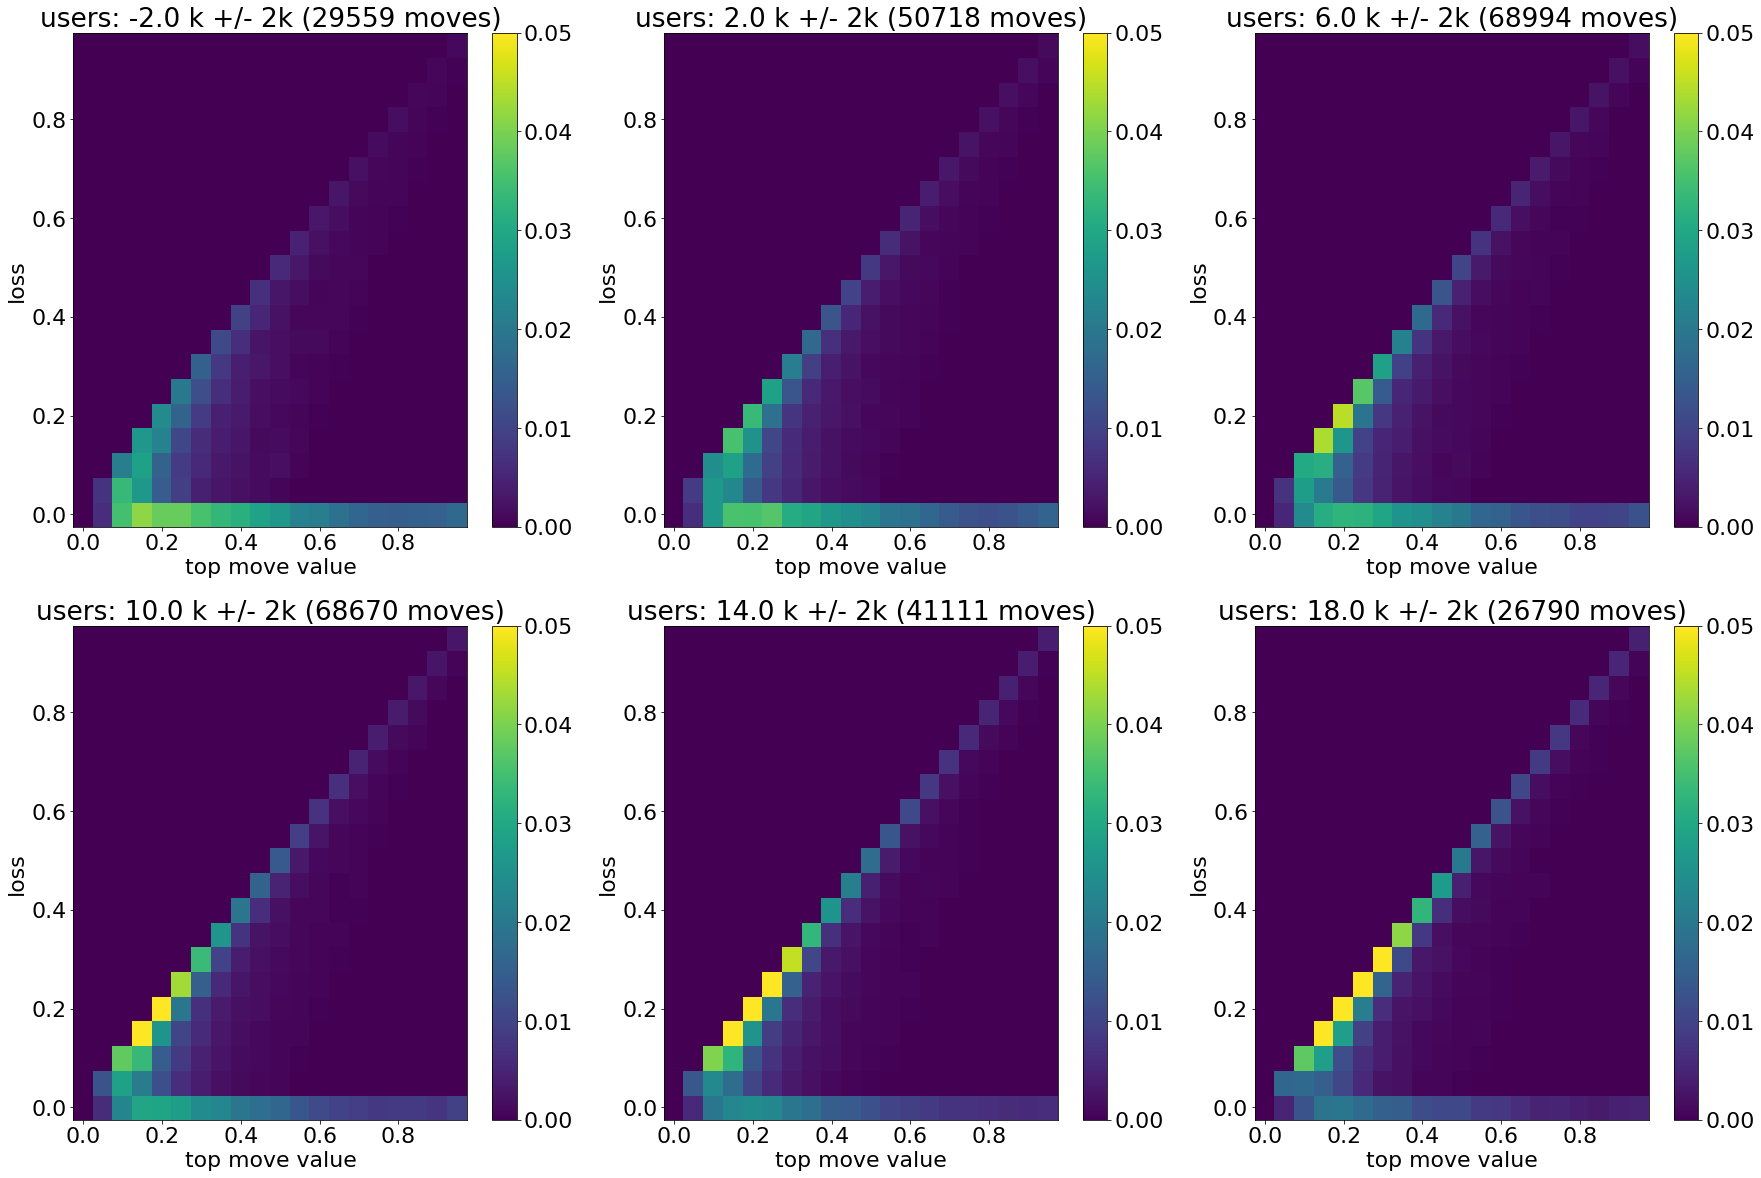

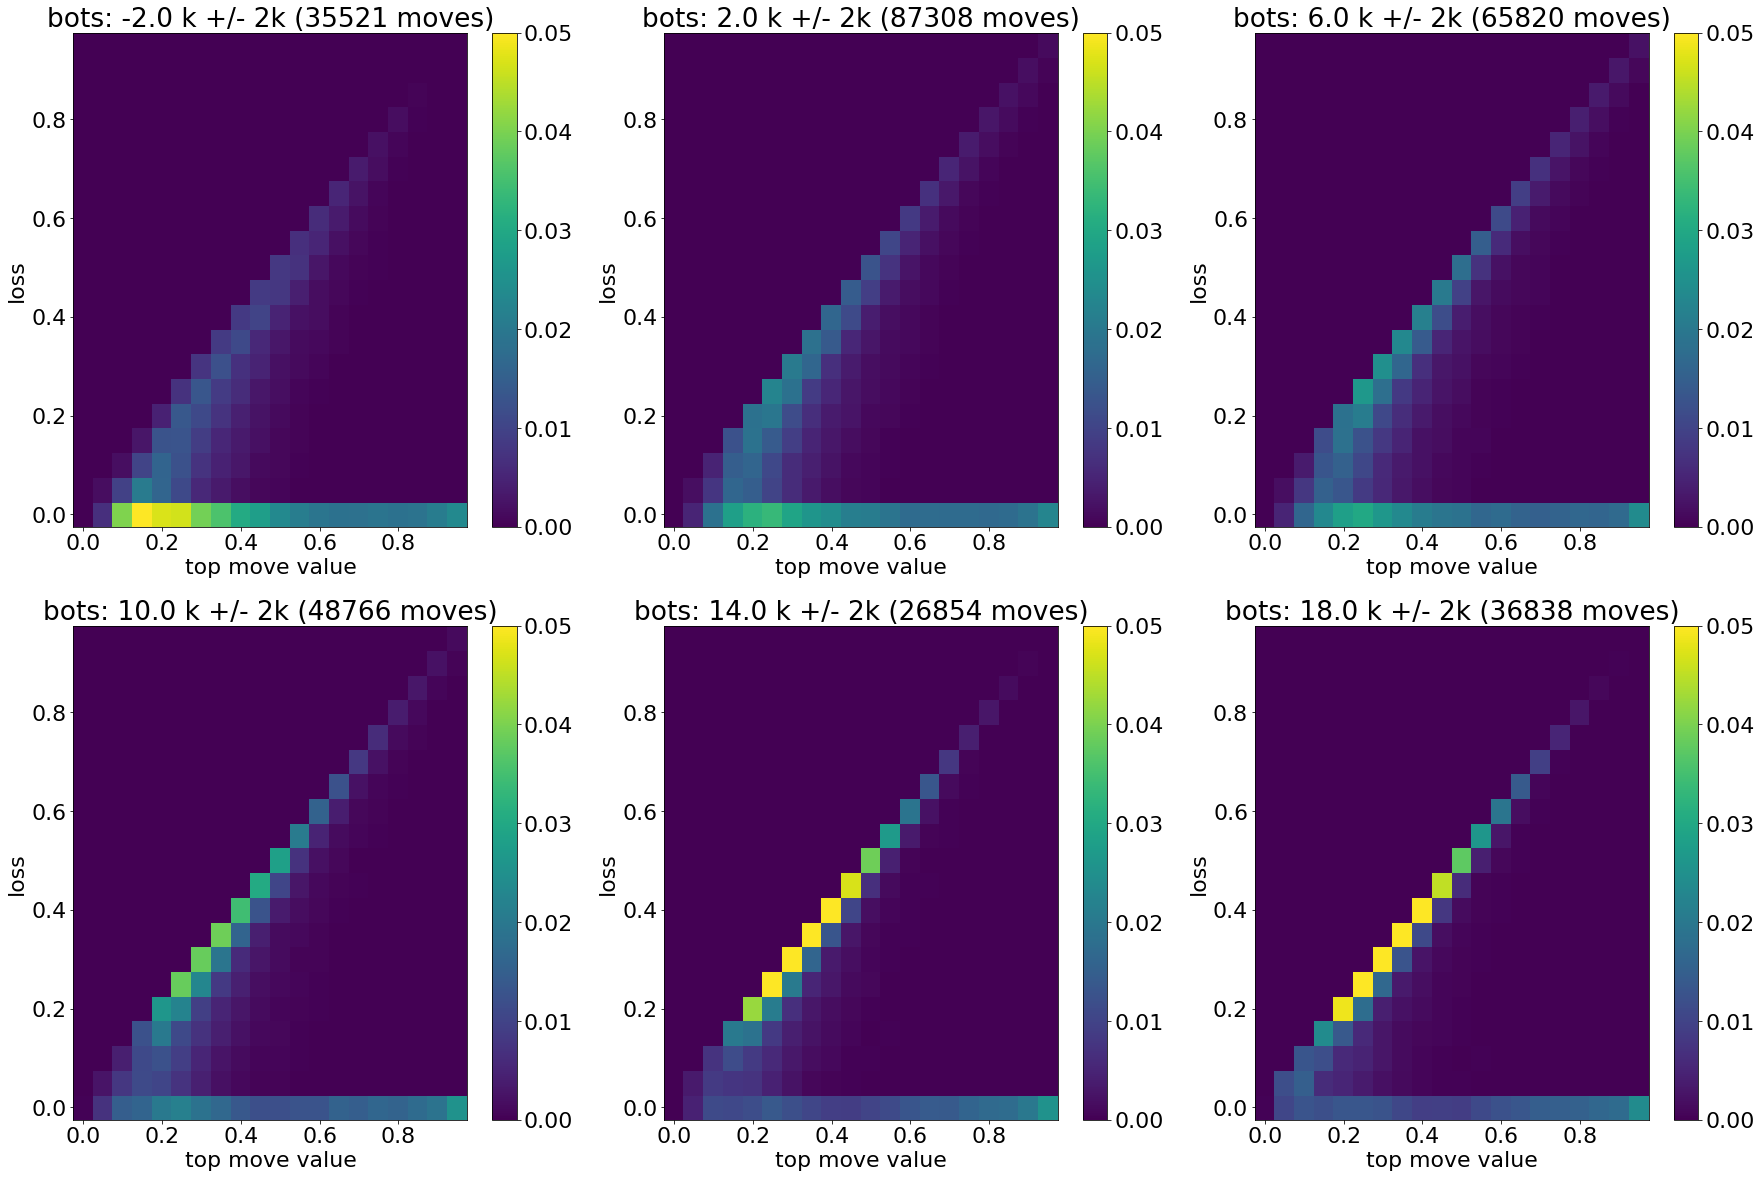

In [16]:
bins = np.arange(-0.025,1.025,0.05)
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        weights = np.ones_like(df.top_value) / len(df.top_value)
        plt.hist2d(df.top_value, df.top_value - df.policy_value,
                            bins=[bins,bins],weights=weights,vmin=0, vmax=0.05)
        plt.title(f"{labels[i]}: {r} k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel('top move value')
        plt.ylabel('loss')
        plt.colorbar()

Text(0.5, 1.0, 'bot moves top policy value')

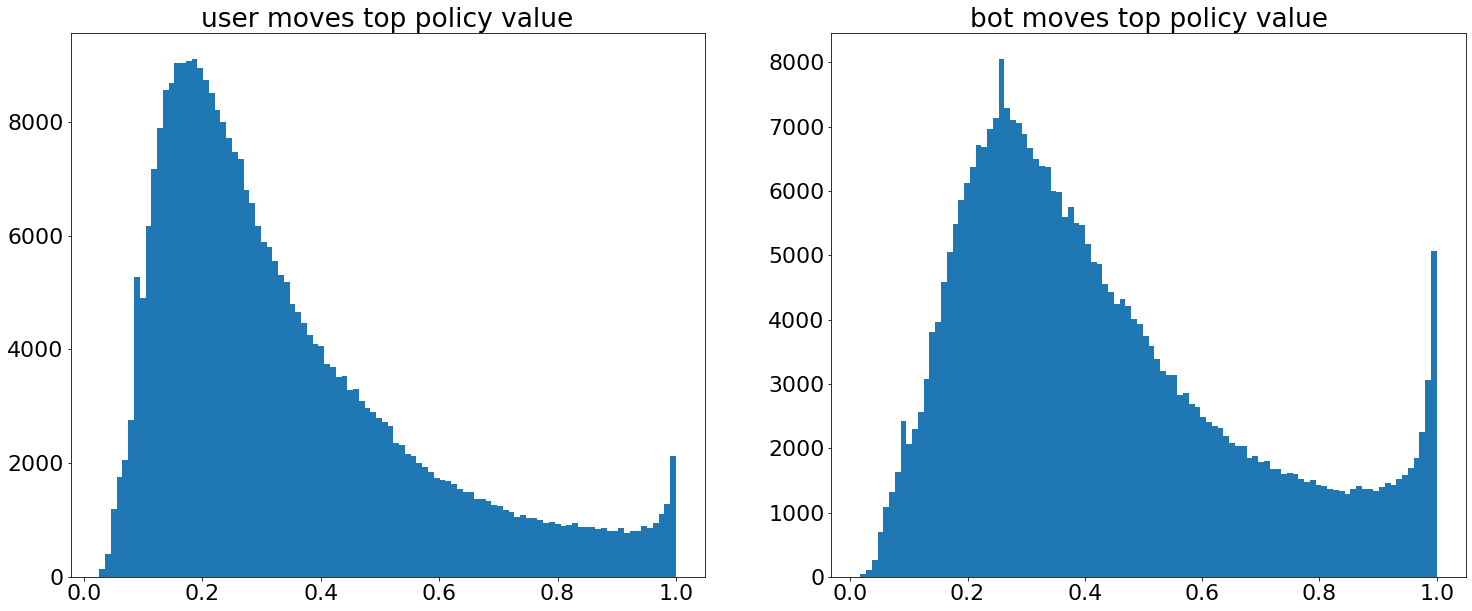

In [17]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1); plt.hist(user_moves.top_value,bins=100); plt.title('user moves top policy value')
plt.subplot(1,2,2); plt.hist(bot_moves.top_value,bins=100); plt.title('bot moves top policy value')

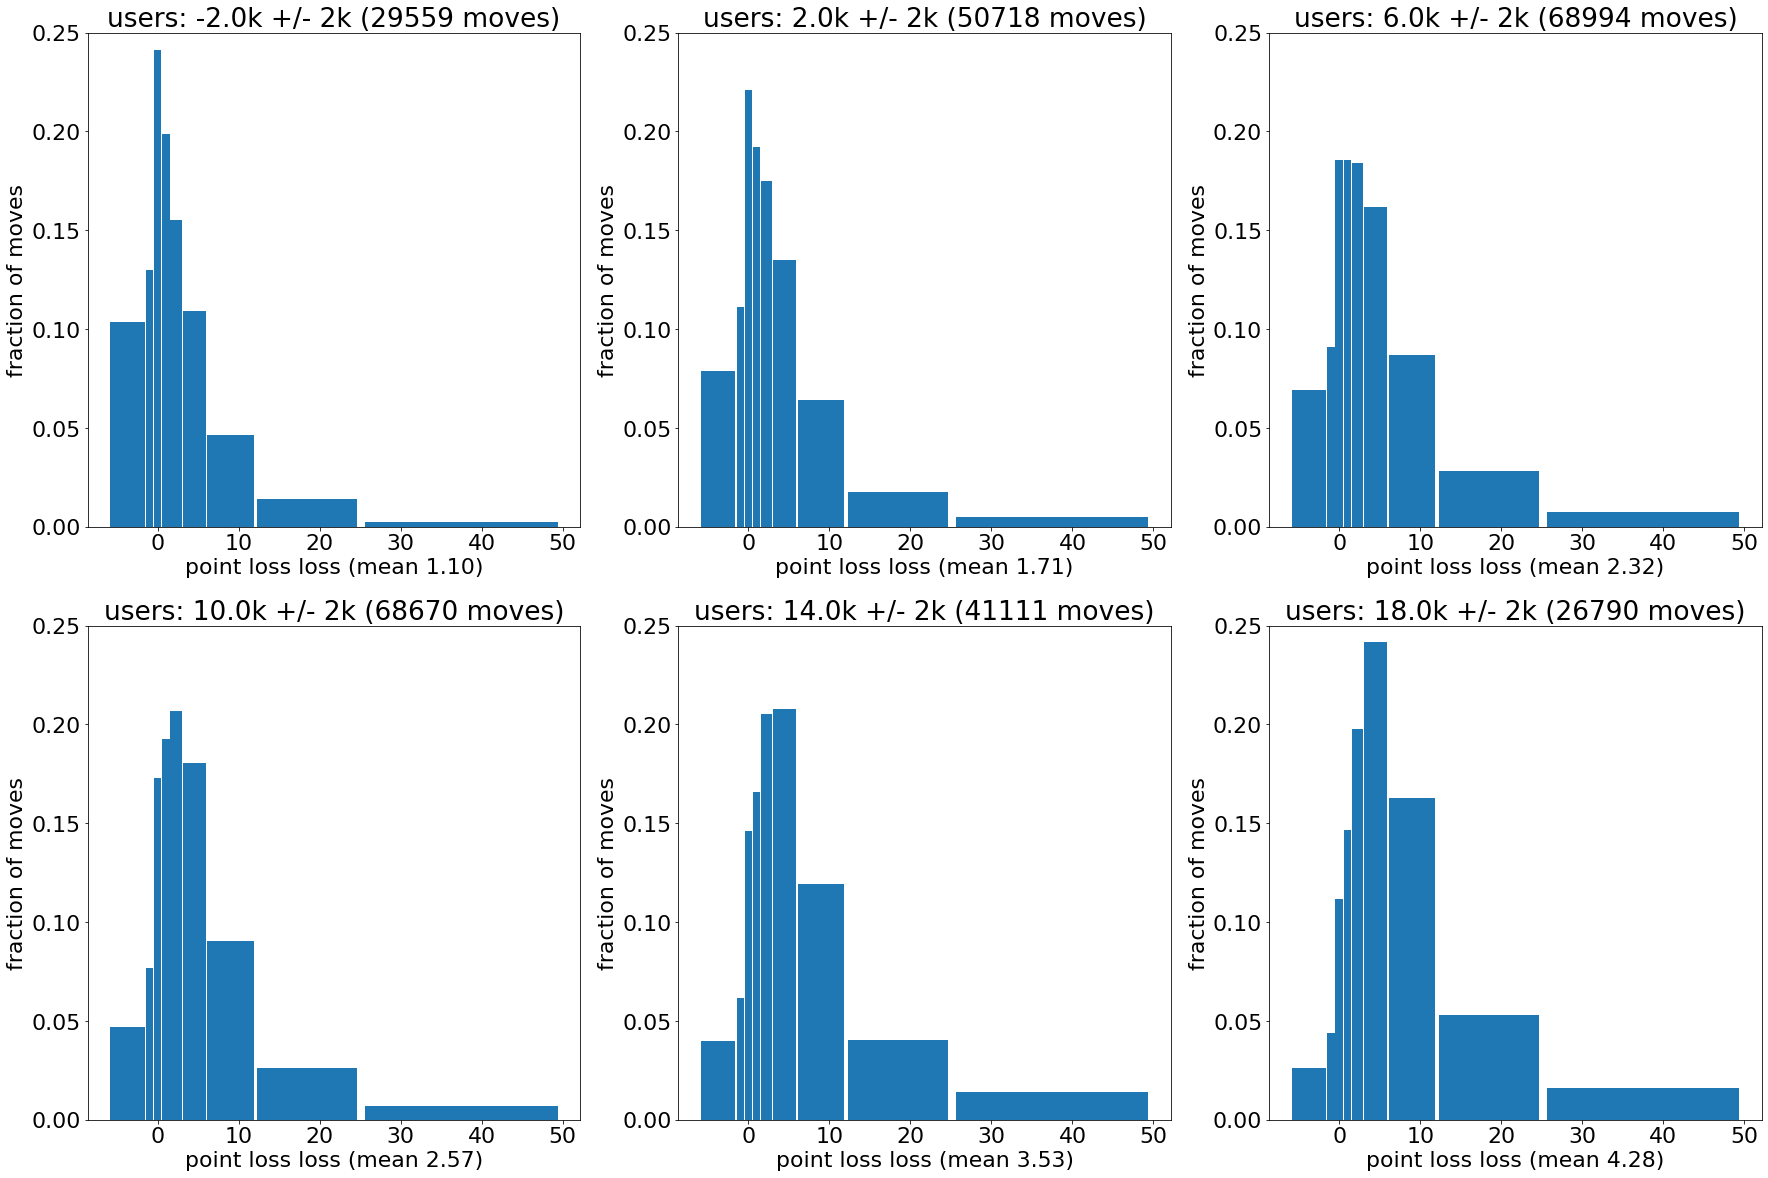

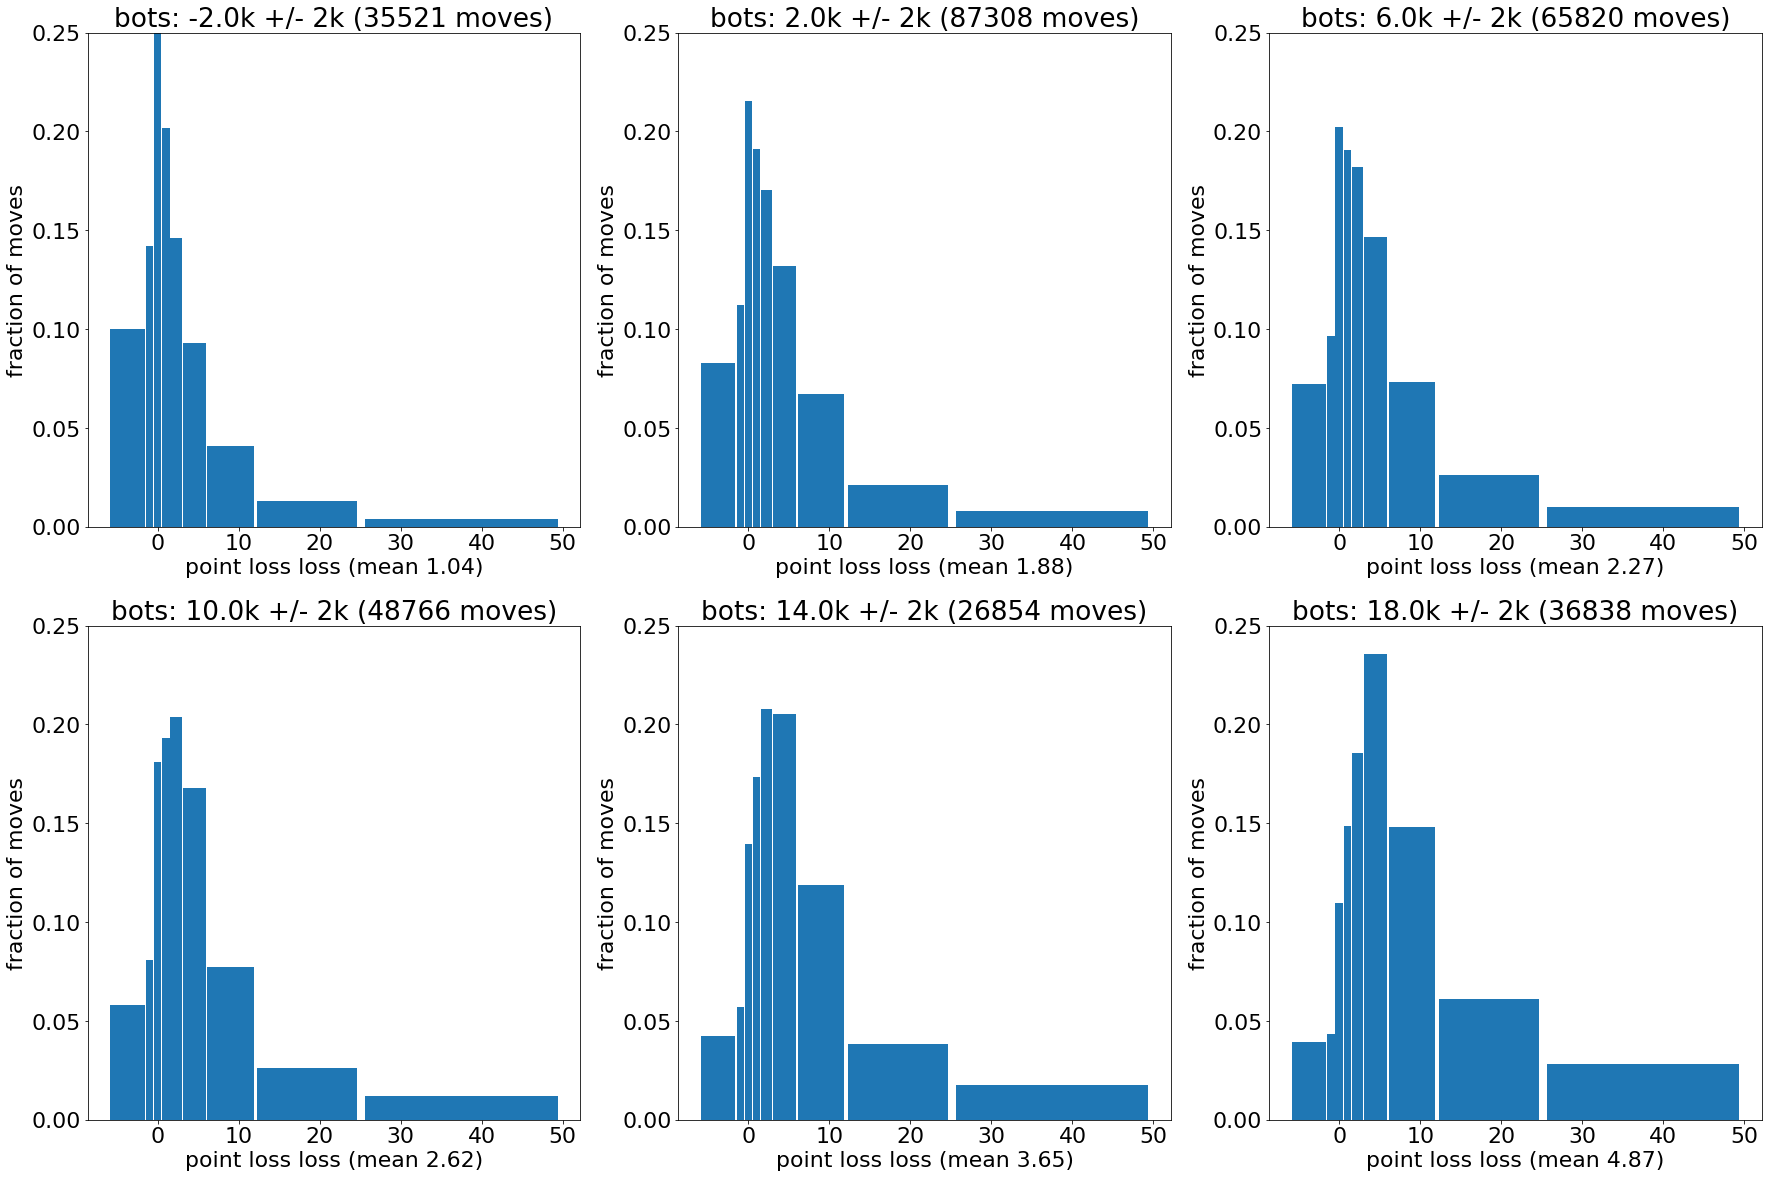

In [18]:
for i,moves in enumerate([user_moves,bot_moves]):
    s = 1
    plt.figure(figsize=(30,20))
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    for r,df in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        plt.subplot(2, 3, s); s=s+1
        normalized_histogram(df.points_lost.clip(-6,50),bins=[-6,-1.5,-0.5,0.5,1.5,3,6,12,25,50],rwidth=0.95)
        plt.title(f"{labels[i]}: {r}k +/- 2k ({df.shape[0]} moves)")
        plt.xlabel(f"point loss loss (mean {df.points_lost.mean():.2f})")
        plt.ylabel('fraction of moves')
        plt.ylim([0,0.25])

In [19]:
user_moves

,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1,24614579,2,361,5,0.046129,0.444669,-1.744846,-0.827782,white,white,16.487680
3,24614579,4,359,3,0.053081,0.277300,-1.632284,0.250725,white,white,16.487680
5,24614579,6,357,1,0.287944,0.355441,-2.491401,-0.276121,white,white,16.487680
7,24614579,8,355,1,0.275457,0.699165,-2.567982,-0.499057,white,white,16.487680
9,24614579,10,353,13,0.000080,0.988561,-3.103060,5.166801,white,white,16.487680
...,...,...,...,...,...,...,...,...,...,...,...
665109,24611188,363,61,56,0.002517,0.058355,-54.880344,0.597866,black,black,20.290232
665111,24611188,365,66,1,0.058981,0.059837,-54.450169,0.008755,black,black,20.290232
665113,24611188,367,66,13,0.022206,0.061852,-54.316521,-0.119301,black,black,20.290232
665115,24611188,369,96,12,0.018413,0.064379,-54.860474,0.420158,black,black,20.290232


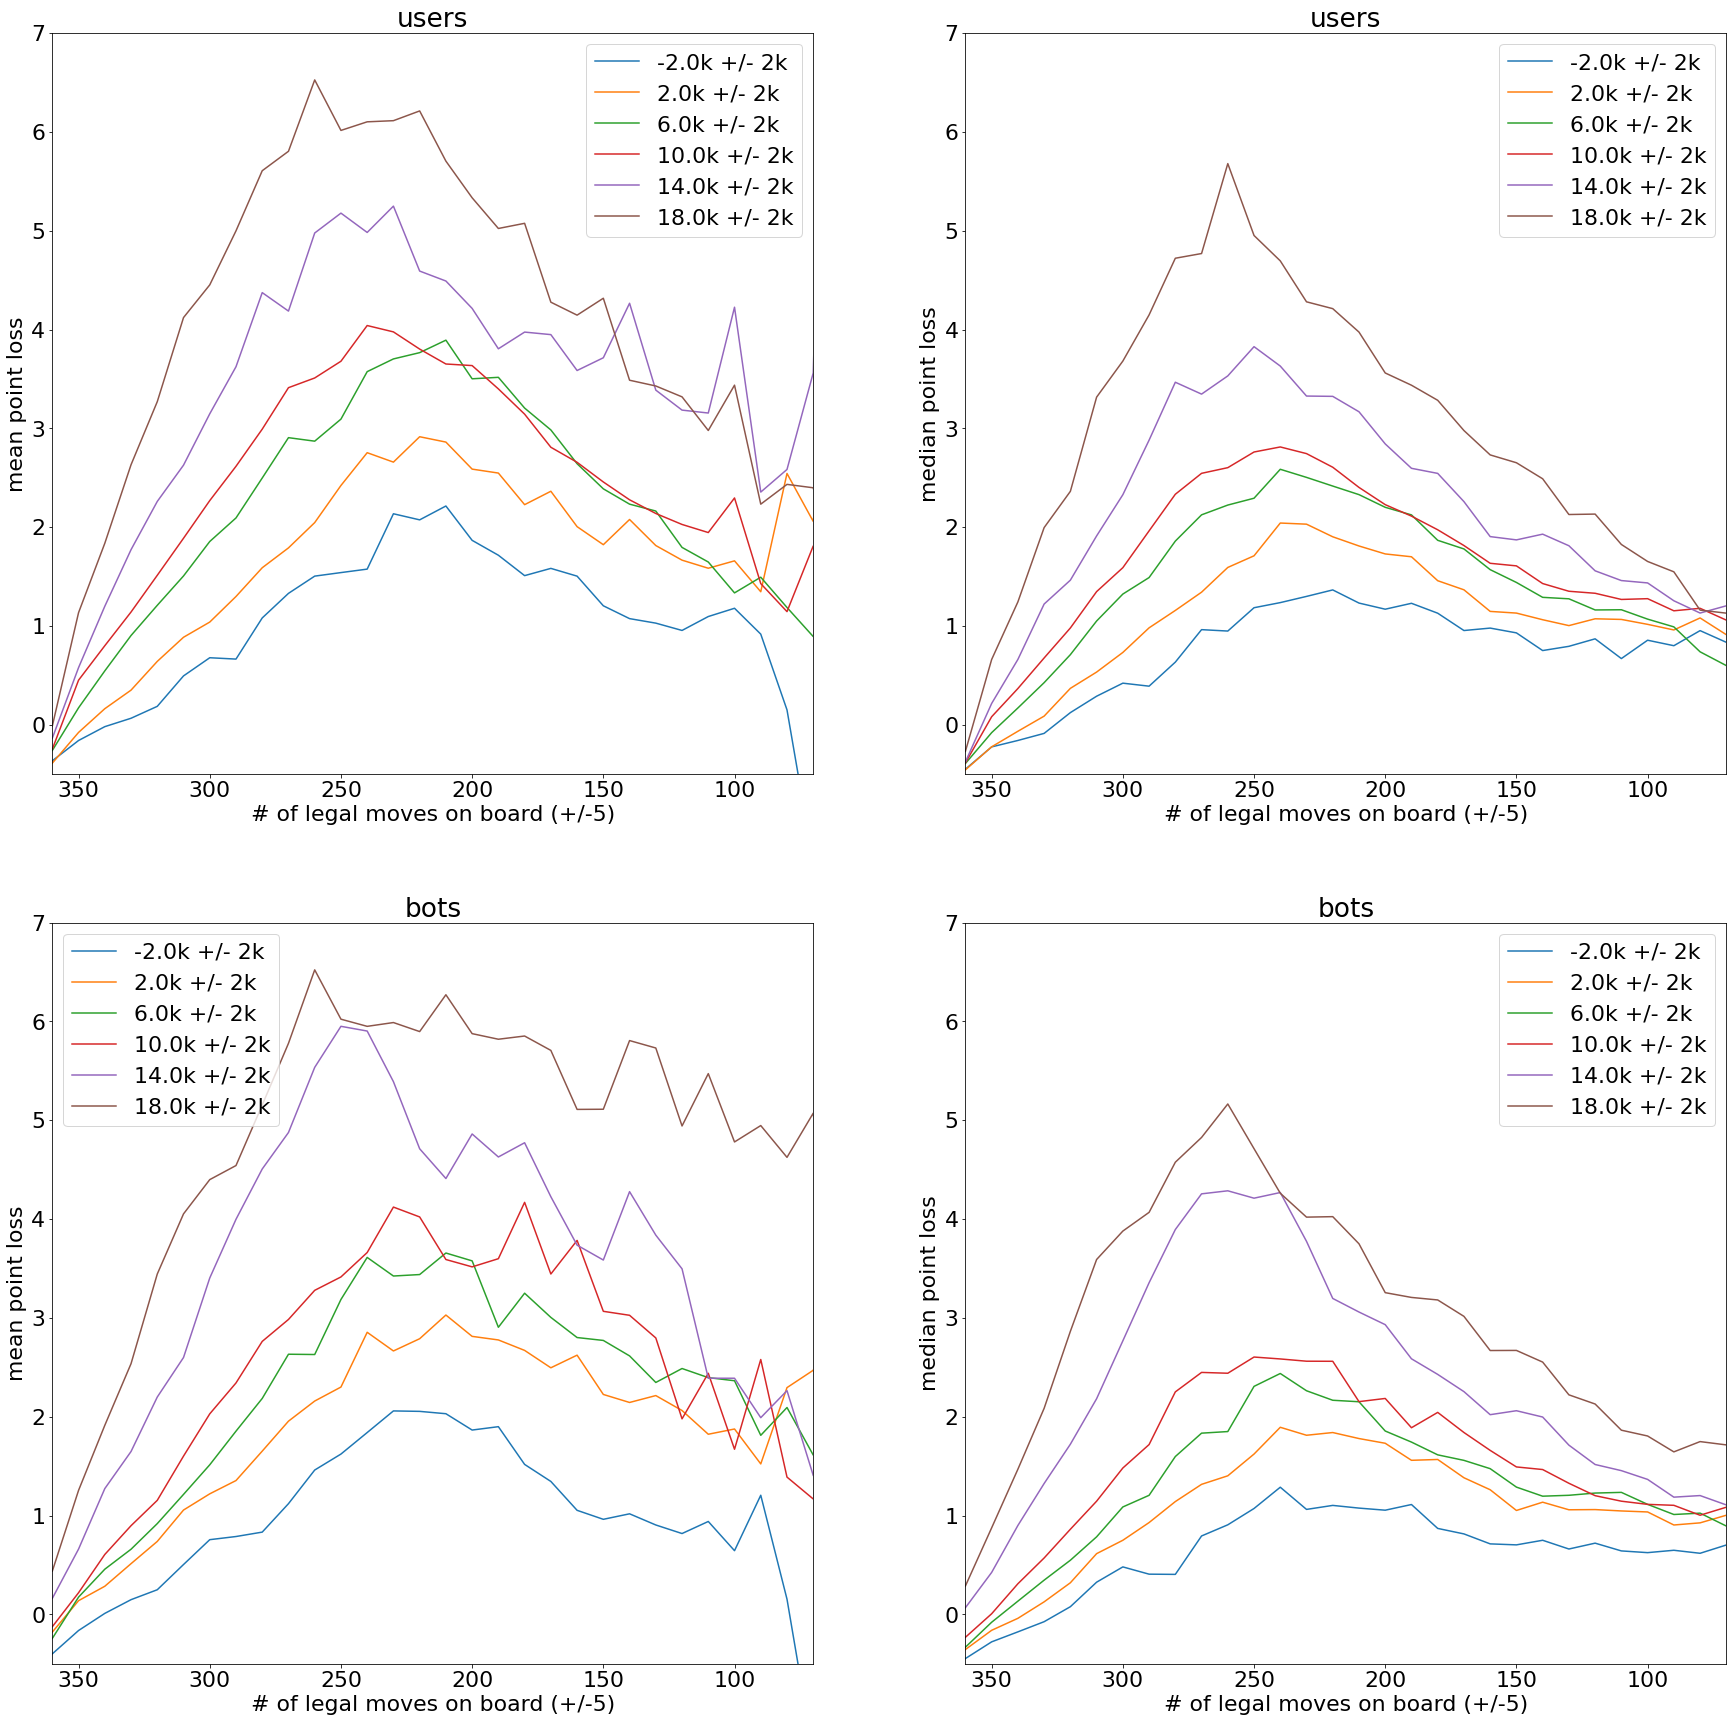

In [36]:
_, axs = plt.subplots(2,2,figsize=(30,30))
for i,moves in enumerate([user_moves,bot_moves]):
    binned_rank = ((moves['rank']-2)/4).round()*4+2
    legends = []
    for r,rdf in moves[(binned_rank >= -2) & (binned_rank <= 18)].groupby(binned_rank):
        binned_num_legal = (rdf.num_legal + 5) // 10
        m = rdf.groupby(binned_num_legal).points_lost.mean()
        axs[i][0].plot(m.index*10,m.values)
        m = rdf.groupby(binned_num_legal).points_lost.median()
        axs[i][1].plot(m.index*10,m.values)
        legends.append(f"{r}k +/- 2k")
    for s in range(2):
        axs[i][s].legend(legends)
        axs[i][s].set_title(labels[i])
        axs[i][s].set_xlabel(f"# of legal moves on board (+/-5)")
        axs[i][s].set_xlim(360,70) # sample size too small after
        axs[i][s].set_ylim(-0.5,7)
    axs[i][0].set_ylabel("mean point loss")
    axs[i][1].set_ylabel("median point loss")

In [ ]:
moves = user_moves[user_moves['rank']<0]
binned_num_legal = (rdf.num_legal + 5) // 10
g = rdf.groupby(binned_num_legal)
m = g.points_lost.mean()
plt.plot(m)

In [34]:
for nl, df in g:
    print(nl,df.points_lost.mean())
    display(df)

4 1.4778156647315392


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
43628,24697423,362,43,1,0.082692,0.121673,-16.579441,0.649475,white,black,17.453154
43632,24697423,366,43,2,0.062828,0.102944,-16.523041,0.492039,white,black,17.453154
43634,24697423,368,43,2,0.064285,0.115637,-16.524836,0.577385,white,black,17.453154
43636,24697423,370,41,5,0.054248,0.120342,-16.474602,0.832096,white,black,17.453154
43638,24697423,372,41,1,0.093183,0.158602,-16.847446,0.358110,white,black,17.453154
43640,24697423,374,40,7,0.045365,0.161643,-16.526484,0.493618,white,black,17.453154
43642,24697423,376,37,3,0.076566,0.168067,-16.289463,0.606583,white,black,17.453154
43644,24697423,378,40,1,0.152314,0.166681,-16.331160,0.842676,white,black,17.453154
43646,24697423,380,40,2,0.085484,0.225024,-16.475620,0.819307,white,black,17.453154
43648,24697423,382,39,0,0.250650,0.250650,-16.326880,1.107546,white,black,17.453154


5 2.183191661286143


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
43620,24697423,354,52,3,0.051337,0.098473,-16.537354,0.945641,white,black,17.453154
43622,24697423,356,50,4,0.043512,0.131460,-16.558931,1.042984,white,black,17.453154
43624,24697423,358,48,2,0.082706,0.130002,-16.688868,0.999266,white,black,17.453154
43626,24697423,360,47,0,0.114043,0.114043,-16.561457,1.099525,white,black,17.453154
43630,24697423,364,46,5,0.052701,0.102517,-16.490751,0.652758,white,black,17.453154
...,...,...,...,...,...,...,...,...,...,...,...
585329,24608139,417,48,0,0.711585,0.711585,38.824898,0.677631,black,white,19.574283
585331,24608139,419,46,2,0.075536,0.180110,39.722107,0.657543,black,white,19.574283
585333,24608139,421,47,9,0.024035,0.201914,37.994652,2.562431,black,white,19.574283
585335,24608139,423,46,9,0.016421,0.204557,37.960144,2.514950,black,white,19.574283


6 2.8969584943464137


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
2208,24676738,336,63,15,0.016351,0.123223,10.516022,0.285878,black,white,19.110230
2210,24676738,338,61,9,0.038226,0.141899,10.529013,0.319283,black,white,19.110230
2212,24676738,340,60,0,0.119683,0.119683,10.779789,-0.057931,black,white,19.110230
2214,24676738,342,59,8,0.026736,0.180808,10.560688,0.036266,black,white,19.110230
2216,24676738,344,58,54,0.003266,0.185799,10.321170,0.290837,black,white,19.110230
...,...,...,...,...,...,...,...,...,...,...,...
628561,24602818,328,63,62,0.000123,0.107204,-32.628754,2.064125,white,black,19.643952
636013,24690227,460,62,9,0.030387,0.103648,-221.363861,33.202560,white,black,18.160841
636015,24690227,462,62,2,0.045847,0.120346,-217.553101,40.326721,white,black,18.160841
636017,24690227,464,64,6,0.036324,0.126055,-215.542099,42.146378,white,black,18.160841


7 5.071168485139288


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
2192,24676738,320,73,0,0.410024,0.410024,11.072659,0.640535,black,white,19.110230
2194,24676738,322,71,12,0.027323,0.084621,10.930266,-0.495297,black,white,19.110230
2196,24676738,324,69,0,0.997824,0.997824,10.756427,-0.153634,black,white,19.110230
2198,24676738,326,67,3,0.050212,0.150467,11.081111,-0.520166,black,white,19.110230
2200,24676738,328,65,8,0.039527,0.124152,11.009950,-0.600674,black,white,19.110230
...,...,...,...,...,...,...,...,...,...,...,...
645560,24608285,412,69,68,0.001007,0.079665,-65.709091,0.786011,white,black,19.654299
662370,24684538,311,73,1,0.079502,0.101140,117.294342,1.995323,black,white,19.227514
663252,24673519,317,74,8,0.012554,0.312836,25.042124,2.361036,black,white,16.248929
663254,24673519,319,73,13,0.006827,0.313090,25.026464,2.558348,black,white,16.248929


8 4.624195462934899


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1565,24695547,292,84,0,0.316056,0.316056,83.511223,0.227295,white,black,17.754929
1567,24695547,294,82,0,0.069334,0.069334,83.154572,0.797150,white,black,17.754929
1569,24695547,296,82,0,0.070781,0.070781,83.154572,1.349228,white,black,17.754929
2182,24676738,310,83,5,0.019083,0.240064,9.352514,0.397933,black,white,19.110230
2184,24676738,312,81,0,0.998419,0.998419,8.883054,0.106328,black,white,19.110230
...,...,...,...,...,...,...,...,...,...,...,...
663250,24673519,315,76,0,0.951684,0.951684,26.514151,45.514925,black,white,16.248929
663258,24673519,323,77,2,0.047785,0.343186,25.158617,2.053211,black,white,16.248929
663260,24673519,325,78,0,0.379104,0.379104,27.356642,0.194788,black,white,16.248929
663262,24673519,327,77,2,0.046804,0.103459,27.249886,0.966503,black,white,16.248929


9 4.945787352797027


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1551,24695547,278,94,5,0.077464,0.208454,89.007088,2.769348,white,black,17.754929
1553,24695547,280,92,3,0.104723,0.186167,89.178490,4.084129,white,black,17.754929
1555,24695547,282,91,0,0.667209,0.667209,83.703072,0.505188,white,black,17.754929
1557,24695547,284,89,6,0.020924,0.200751,86.421494,4.233543,white,black,17.754929
1559,24695547,286,89,5,0.021679,0.190473,85.922966,1.724945,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663236,24673519,301,89,0,0.346591,0.346591,70.228035,-0.197739,black,white,16.248929
663238,24673519,303,87,1,0.344184,0.405961,69.027863,1.029724,black,white,16.248929
663240,24673519,305,85,10,0.008210,0.540562,69.139153,3.425751,black,white,16.248929
663873,24695845,276,93,0,0.940561,0.940561,-24.566238,-0.151669,white,black,17.644361


10 4.77997109115589


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1541,24695547,268,104,2,0.172392,0.213590,92.744270,1.009766,white,black,17.754929
1543,24695547,270,103,7,0.033764,0.216690,94.066391,1.546410,white,black,17.754929
1545,24695547,272,101,7,0.026731,0.301358,90.699516,0.675240,white,black,17.754929
1547,24695547,274,98,0,0.253812,0.253812,90.957336,-0.063866,white,black,17.754929
1549,24695547,276,96,7,0.024571,0.188606,90.904526,3.155983,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663863,24695845,266,101,0,0.996306,0.996306,-2.249410,-0.093676,white,black,17.644361
663865,24695845,268,101,0,0.464552,0.464552,-3.719678,-0.657490,white,black,17.644361
663867,24695845,270,99,12,0.004022,0.252478,-2.600677,1.195926,white,black,17.644361
663869,24695845,272,97,0,0.915334,0.915334,-2.796975,-0.210137,white,black,17.644361


11 5.471135447192065


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1531,24695547,258,114,5,0.093935,0.159605,95.055481,2.101982,white,black,17.754929
1533,24695547,260,112,6,0.027476,0.167310,94.270416,2.688034,white,black,17.754929
1535,24695547,262,110,5,0.025121,0.271618,92.885124,3.650467,white,black,17.754929
1537,24695547,264,108,10,0.013248,0.247490,92.845612,3.980949,white,black,17.754929
1539,24695547,266,106,23,0.001701,0.237439,97.508736,7.725037,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663851,24695845,254,114,0,0.595604,0.595604,-5.770482,0.429012,white,black,17.644361
663853,24695845,256,112,7,0.020307,0.279227,-7.653817,1.099457,white,black,17.644361
663855,24695845,258,110,17,0.005906,0.238446,-5.669546,2.045232,white,black,17.644361
663857,24695845,260,108,0,0.821827,0.821827,-5.494621,0.451970,white,black,17.644361


12 4.941687341134602


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1511,24695547,238,123,14,0.004662,0.247004,93.868927,4.747948,white,black,17.754929
1513,24695547,240,121,1,0.153448,0.422213,92.638596,0.817505,white,black,17.754929
1515,24695547,242,124,5,0.038296,0.395378,98.243500,6.704033,white,black,17.754929
1517,24695547,244,123,28,0.000945,0.374271,100.656853,9.795380,white,black,17.754929
1519,24695547,246,121,14,0.004049,0.340114,99.904793,8.369667,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663841,24695845,244,124,0,0.997354,0.997354,-2.076385,0.861689,white,black,17.644361
663843,24695845,246,122,0,0.975112,0.975112,-2.042449,0.453243,white,black,17.644361
663845,24695845,248,120,5,0.021030,0.319449,-2.689468,1.369523,white,black,17.644361
663847,24695845,250,118,0,0.644808,0.644808,-2.705477,1.028249,white,black,17.644361


13 5.730525563285042


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1501,24695547,228,133,15,0.002898,0.325257,98.945625,7.486832,white,black,17.754929
1503,24695547,230,131,45,0.000575,0.236839,101.933311,11.103897,white,black,17.754929
1505,24695547,232,130,1,0.191237,0.211637,98.076759,2.418808,white,black,17.754929
1507,24695547,234,128,15,0.005979,0.260511,103.007553,10.581680,white,black,17.754929
1509,24695547,236,126,8,0.012951,0.307127,99.792046,6.281532,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663186,24673519,251,126,8,0.021587,0.257246,68.129219,6.420326,black,white,16.248929
663833,24695845,236,134,13,0.003493,0.332198,-1.906653,1.432451,white,black,17.644361
663835,24695845,238,131,0,0.739465,0.739465,-2.870244,0.009833,white,black,17.644361
663837,24695845,240,128,7,0.016328,0.318004,-3.558304,0.689175,white,black,17.644361


14 5.805694608774771


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1491,24695547,218,144,30,0.001081,0.168552,93.317078,5.956192,white,black,17.754929
1493,24695547,220,142,11,0.011760,0.292593,95.589783,3.927177,white,black,17.754929
1495,24695547,222,140,1,0.231206,0.234076,94.859558,0.225029,white,black,17.754929
1497,24695547,224,138,0,0.689198,0.689198,93.217407,2.096794,white,black,17.754929
1499,24695547,226,135,14,0.004878,0.320084,94.277855,8.869446,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663823,24695845,226,143,0,0.987545,0.987545,-3.361078,0.695998,white,black,17.644361
663825,24695845,228,142,4,0.047697,0.484430,-9.377855,2.553049,white,black,17.644361
663827,24695845,230,140,11,0.007811,0.499977,-5.734283,5.743807,white,black,17.644361
663829,24695845,232,138,14,0.001591,0.422504,-3.615497,4.722806,white,black,17.644361


15 5.110825784921713


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1481,24695547,208,154,18,0.002801,0.458497,78.465706,6.478943,white,black,17.754929
1483,24695547,210,152,10,0.007694,0.421908,83.556427,7.167603,white,black,17.754929
1485,24695547,212,150,11,0.010215,0.304497,86.108772,5.834305,white,black,17.754929
1487,24695547,214,148,18,0.004543,0.188470,88.686203,5.010986,white,black,17.754929
1489,24695547,216,146,44,0.000811,0.290731,92.070335,6.949577,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663813,24695845,216,154,34,0.000532,0.251199,-4.237094,1.619701,white,black,17.644361
663815,24695845,218,152,5,0.030359,0.247918,-6.285810,0.667038,white,black,17.644361
663817,24695845,220,150,1,0.148828,0.176435,-7.290677,-0.213896,white,black,17.644361
663819,24695845,222,147,54,0.000107,0.272203,-2.051745,5.470375,white,black,17.644361


16 5.1092869981987805


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1473,24695547,200,163,65,0.000516,0.371582,81.901337,5.423843,white,black,17.754929
1475,24695547,202,160,2,0.045362,0.568936,80.624207,5.366112,white,black,17.754929
1477,24695547,204,157,7,0.011622,0.479851,79.798737,5.042526,white,black,17.754929
1479,24695547,206,155,23,0.001595,0.423869,79.397423,5.435799,white,black,17.754929
2090,24676738,218,164,0,0.955121,0.955121,-8.527249,0.725237,black,white,19.110230
...,...,...,...,...,...,...,...,...,...,...,...
663803,24695845,206,163,2,0.101931,0.494503,-3.379844,0.831659,white,black,17.644361
663805,24695845,208,162,0,0.625321,0.625321,-3.748411,0.591512,white,black,17.644361
663807,24695845,210,160,21,0.001033,0.288796,-3.070391,4.463896,white,black,17.644361
663809,24695845,212,158,0,0.570698,0.570698,-6.457006,-1.883121,white,black,17.644361


17 5.706118453781407


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1463,24695547,190,174,5,0.062600,0.182381,78.612274,2.459084,white,black,17.754929
1465,24695547,192,171,13,0.009206,0.171524,79.256813,3.321419,white,black,17.754929
1467,24695547,194,169,1,0.142758,0.196319,75.904198,1.085243,white,black,17.754929
1469,24695547,196,167,21,0.002179,0.195278,79.873428,7.073608,white,black,17.754929
1471,24695547,198,165,14,0.007550,0.211680,76.740868,3.903610,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663793,24695845,196,172,44,0.000026,0.675171,-13.468598,88.819404,white,black,17.644361
663795,24695845,198,170,0,0.637419,0.637419,-5.404122,9.460710,white,black,17.644361
663797,24695845,200,169,0,0.972443,0.972443,-6.259949,0.525476,white,black,17.644361
663799,24695845,202,167,106,0.000024,0.453977,-1.474589,14.731999,white,black,17.644361


18 5.851675174470826


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1455,24695547,182,182,0,0.307221,0.307221,92.831581,2.859360,white,black,17.754929
1457,24695547,184,180,0,0.236620,0.236620,83.490280,1.291748,white,black,17.754929
1459,24695547,186,178,5,0.040223,0.268659,78.107666,2.938614,white,black,17.754929
1461,24695547,188,176,32,0.000938,0.286235,81.088005,5.374290,white,black,17.754929
2068,24676738,196,183,3,0.151124,0.212615,-30.010702,1.186430,black,white,19.110230
...,...,...,...,...,...,...,...,...,...,...,...
663783,24695845,186,183,9,0.009806,0.423308,-96.073921,5.752251,white,black,17.644361
663785,24695845,188,181,5,0.050408,0.228498,-94.253868,6.414276,white,black,17.644361
663787,24695845,190,179,87,0.000113,0.549300,-85.621651,16.133118,white,black,17.644361
663789,24695845,192,177,8,0.016059,0.491840,-95.605797,5.782791,white,black,17.644361


19 5.819215746616301


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1443,24695547,170,194,1,0.221971,0.274354,78.197235,1.348404,white,black,17.754929
1445,24695547,172,192,2,0.083276,0.478681,80.747719,4.038696,white,black,17.754929
1447,24695547,174,190,4,0.049218,0.317808,84.729599,3.134117,white,black,17.754929
1449,24695547,176,188,10,0.004017,0.423925,93.588707,11.171700,white,black,17.754929
1451,24695547,178,186,3,0.103982,0.226065,95.031281,1.702026,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663773,24695845,176,193,0,0.635544,0.635544,-91.635277,2.933716,white,black,17.644361
663775,24695845,178,190,0,0.212841,0.212841,-94.773643,5.552246,white,black,17.644361
663777,24695845,180,188,5,0.006414,0.462685,-82.354843,12.501358,white,black,17.644361
663779,24695845,182,187,0,0.742523,0.742523,-101.870567,1.279510,white,black,17.644361


20 5.875790990906057


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1435,24695547,162,203,16,0.001974,0.320042,80.943924,6.002266,white,black,17.754929
1437,24695547,164,201,1,0.181439,0.210709,82.273430,1.560440,white,black,17.754929
1439,24695547,166,198,10,0.005876,0.360806,81.736427,7.440117,white,black,17.754929
1441,24695547,168,196,10,0.005440,0.292817,84.995605,8.145493,white,black,17.754929
2046,24676738,174,202,11,0.007450,0.369285,-26.772245,0.368046,black,white,19.110230
...,...,...,...,...,...,...,...,...,...,...,...
663763,24695845,166,203,0,0.816357,0.816357,-83.786873,-1.044418,white,black,17.644361
663765,24695845,168,201,21,0.002104,0.220474,-85.333817,4.538788,white,black,17.644361
663767,24695845,170,199,4,0.057112,0.317832,-83.595596,3.752510,white,black,17.644361
663769,24695845,172,197,18,0.001175,0.688614,-70.399445,16.657906,white,black,17.644361


21 6.269352572051422


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1423,24695547,150,214,24,0.001176,0.247856,60.566570,6.240040,white,black,17.754929
1425,24695547,152,212,75,0.000216,0.247735,66.168388,11.209850,white,black,17.754929
1427,24695547,154,210,23,0.001979,0.325277,68.001579,7.051636,white,black,17.754929
1429,24695547,156,208,3,0.074777,0.413022,72.489662,3.062019,white,black,17.754929
1431,24695547,158,206,9,0.008052,0.455487,81.637749,10.470917,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663753,24695845,156,213,42,0.000415,0.276541,-81.579170,8.479881,white,black,17.644361
663755,24695845,158,211,0,0.387524,0.387524,-80.909157,4.787033,white,black,17.644361
663757,24695845,160,209,25,0.000477,0.244530,-77.200500,7.815742,white,black,17.644361
663759,24695845,162,207,22,0.000858,0.299616,-73.662994,10.407043,white,black,17.644361


22 5.896711936590705


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1413,24695547,140,222,27,0.001414,0.240468,47.469624,4.031071,white,black,17.754929
1415,24695547,142,220,3,0.101689,0.233404,43.219589,1.229256,white,black,17.754929
1417,24695547,144,218,6,0.019690,0.358228,47.394024,3.290325,white,black,17.754929
1419,24695547,146,218,10,0.006997,0.308991,47.860527,2.335060,white,black,17.754929
1421,24695547,148,216,132,0.000154,0.342936,56.752552,10.788143,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663743,24695845,146,223,0,0.849263,0.849263,-17.679369,1.919714,white,black,17.644361
663745,24695845,148,221,26,0.000362,0.503682,-20.758350,8.625235,white,black,17.644361
663747,24695845,150,219,4,0.040613,0.452671,-17.092188,5.416883,white,black,17.644361
663749,24695845,152,217,0,0.994989,0.994989,-76.627541,4.930893,white,black,17.644361


23 5.987992027459588


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1403,24695547,130,234,0,0.683170,0.683170,40.304317,-4.530132,white,black,17.754929
1405,24695547,132,232,42,0.000900,0.175056,48.971291,3.678848,white,black,17.754929
1407,24695547,134,230,42,0.000848,0.205282,47.286278,3.596783,white,black,17.754929
1409,24695547,136,228,16,0.005054,0.301846,46.007702,1.560005,white,black,17.754929
1411,24695547,138,226,15,0.004700,0.304186,47.490345,6.925175,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663733,24695845,136,232,4,0.064748,0.244558,-74.789085,6.020271,white,black,17.644361
663735,24695845,138,231,36,0.000008,0.508622,-12.668807,64.237298,white,black,17.644361
663737,24695845,140,229,34,0.000297,0.637739,-7.976504,9.245826,white,black,17.644361
663739,24695845,142,227,26,0.000695,0.495993,-8.208808,8.315249,white,black,17.644361


24 5.9496239013882795


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1391,24695547,118,244,10,0.006914,0.534205,48.861801,7.560799,white,black,17.754929
1393,24695547,120,242,5,0.024910,0.385715,39.989834,-1.280476,white,black,17.754929
1395,24695547,122,242,69,0.000279,0.542705,51.487961,7.767689,white,black,17.754929
1397,24695547,124,240,32,0.000861,0.593219,49.064945,5.747299,white,black,17.754929
1399,24695547,126,238,36,0.000768,0.531362,49.296230,6.653118,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663721,24695845,124,244,5,0.056538,0.355306,-67.941505,5.669121,white,black,17.644361
663723,24695845,126,242,109,0.000067,0.526394,-32.217850,44.008904,white,black,17.644361
663725,24695845,128,240,0,0.864138,0.864138,-68.444801,1.059845,white,black,17.644361
663727,24695845,130,238,0,0.882827,0.882827,-72.490173,2.218048,white,black,17.644361


25 6.022052669296442


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1381,24695547,108,254,11,0.012128,0.249069,25.463112,2.502829,white,black,17.754929
1383,24695547,110,252,4,0.016950,0.497571,31.520391,4.083431,white,black,17.754929
1385,24695547,112,250,130,0.000183,0.492179,40.364777,11.587484,white,black,17.754929
1387,24695547,114,248,18,0.002322,0.550498,35.160057,3.456902,white,black,17.754929
1389,24695547,116,246,27,0.001552,0.575080,44.488121,6.794350,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663711,24695845,114,254,54,0.000264,0.182675,-44.536270,14.903835,white,black,17.644361
663713,24695845,116,252,22,0.003647,0.286421,-51.583965,8.335979,white,black,17.644361
663715,24695845,118,250,0,0.973974,0.973974,-53.676121,6.063190,white,black,17.644361
663717,24695845,120,248,0,0.838778,0.838778,-55.607075,7.167713,white,black,17.644361


26 6.521005762324092


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1371,24695547,98,264,67,0.000292,0.346849,29.125118,7.267927,white,black,17.754929
1373,24695547,100,262,19,0.001623,0.348088,28.717667,9.863379,white,black,17.754929
1375,24695547,102,260,14,0.005203,0.336047,26.603029,3.354893,white,black,17.754929
1377,24695547,104,258,33,0.001586,0.226582,25.731958,3.639557,white,black,17.754929
1379,24695547,106,256,50,0.000507,0.173580,24.870508,5.312597,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663701,24695845,104,264,17,0.001267,0.533982,-34.920174,14.353531,white,black,17.644361
663703,24695845,106,262,0,0.447882,0.447882,-44.445759,3.130043,white,black,17.644361
663705,24695845,108,260,9,0.006152,0.519973,-41.720806,4.608047,white,black,17.644361
663707,24695845,110,258,0,0.790827,0.790827,-43.186806,2.642864,white,black,17.644361


27 5.777631662281944


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1363,24695547,90,273,3,0.058057,0.384893,11.156780,3.254371,white,black,17.754929
1365,24695547,92,271,16,0.000514,0.649965,16.833364,7.889590,white,black,17.754929
1367,24695547,94,268,31,0.000464,0.345250,23.377264,7.325577,white,black,17.754929
1369,24695547,96,266,120,0.000170,0.385452,29.168921,8.423126,white,black,17.754929
1958,24676738,86,273,90,0.000022,0.401095,0.358513,4.430060,black,white,19.110230
...,...,...,...,...,...,...,...,...,...,...,...
663036,24673519,101,266,0,0.592571,0.592571,59.544552,2.316025,black,white,16.248929
663693,24695845,96,273,74,0.000183,0.603099,-37.137356,12.498070,white,black,17.644361
663695,24695845,98,271,10,0.005793,0.328711,-35.826931,10.189766,white,black,17.644361
663697,24695845,100,268,16,0.003709,0.440914,-41.858803,10.757324,white,black,17.644361


28 5.153601480928449


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1353,24695547,80,284,0,0.889174,0.889174,3.773413,-0.749790,white,black,17.754929
1355,24695547,82,282,55,0.000038,0.393813,4.650445,3.949493,white,black,17.754929
1357,24695547,84,280,134,0.000009,0.360781,3.788085,5.376028,white,black,17.754929
1359,24695547,86,278,66,0.000027,0.358446,9.326281,7.096877,white,black,17.754929
1361,24695547,88,275,6,0.043560,0.335557,7.923028,0.224225,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663683,24695845,86,281,3,0.052470,0.468373,-27.463243,6.163984,white,black,17.644361
663685,24695845,88,280,0,0.720655,0.720655,-34.890690,-4.149984,white,black,17.644361
663687,24695845,90,279,0,0.888836,0.888836,-44.087570,-0.207088,white,black,17.644361
663689,24695845,92,277,0,0.956796,0.956796,-43.022808,-0.854832,white,black,17.644361


29 4.541249593942875


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1343,24695547,70,294,10,0.000138,0.894723,7.931489,2.828304,white,black,17.754929
1345,24695547,72,292,11,0.002715,0.418083,15.277575,4.422143,white,black,17.754929
1347,24695547,74,290,7,0.001700,0.535420,11.140419,3.597152,white,black,17.754929
1349,24695547,76,288,2,0.154140,0.457482,10.331960,0.901008,white,black,17.754929
1351,24695547,78,286,2,0.137261,0.368552,10.380149,2.586983,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663669,24695845,72,294,18,0.004804,0.453764,-37.024254,6.795437,white,black,17.644361
663671,24695845,74,292,11,0.001859,0.288903,-32.879841,6.987411,white,black,17.644361
663673,24695845,76,290,10,0.001175,0.337922,-33.390587,12.348419,white,black,17.644361
663675,24695845,78,288,6,0.009374,0.331027,-37.533970,11.244263,white,black,17.644361


30 4.398799651508268


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1333,24695547,60,304,70,0.000057,0.515872,15.469918,3.684188,white,black,17.754929
1335,24695547,62,302,53,0.000187,0.463643,19.429556,3.938212,white,black,17.754929
1337,24695547,64,300,16,0.001351,0.523291,15.447680,1.535004,white,black,17.754929
1339,24695547,66,298,0,0.807629,0.807629,5.236970,-0.659891,white,black,17.754929
1341,24695547,68,296,10,0.001637,0.417003,6.100757,-1.663576,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663659,24695845,62,304,14,0.008637,0.142058,-21.145008,3.001410,white,black,17.644361
663661,24695845,64,302,23,0.001082,0.442995,-26.244278,2.157461,white,black,17.644361
663663,24695845,66,300,2,0.055622,0.402481,-27.391907,2.005470,white,black,17.644361
663665,24695845,68,298,2,0.100397,0.164491,-34.497467,3.358521,white,black,17.644361


31 4.052149047849407


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1323,24695547,50,314,8,0.002713,0.508362,1.311864,-0.219577,white,black,17.754929
1325,24695547,52,312,81,0.000031,0.338992,6.983148,3.756743,white,black,17.754929
1327,24695547,54,310,4,0.108933,0.341439,6.022230,-1.660208,white,black,17.754929
1329,24695547,56,308,70,0.000042,0.447987,10.619759,1.988046,white,black,17.754929
1331,24695547,58,306,27,0.000149,0.666920,11.675513,1.157315,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663647,24695845,50,314,1,0.211630,0.388415,-6.960155,-0.787402,white,black,17.644361
663649,24695845,52,312,43,0.000009,0.457380,1.086030,9.810562,white,black,17.644361
663651,24695845,54,310,0,0.839313,0.839313,-4.570665,-1.198117,white,black,17.644361
663653,24695845,56,308,0,0.900040,0.900040,-5.625595,4.360669,white,black,17.644361


32 3.4437532790392043


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1313,24695547,40,324,7,0.003645,0.488367,6.800589,-0.860713,white,black,17.754929
1315,24695547,42,322,0,0.853369,0.853369,3.993896,-4.200501,white,black,17.754929
1317,24695547,44,320,1,0.201345,0.507030,4.266680,-1.903506,white,black,17.754929
1319,24695547,46,318,4,0.074409,0.270443,4.326199,-0.456336,white,black,17.754929
1321,24695547,48,316,0,0.904774,0.904774,2.720240,-1.388986,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663637,24695845,40,324,53,0.000067,0.510398,4.515574,2.347716,white,black,17.644361
663639,24695845,42,322,37,0.000193,0.436949,2.464592,0.231466,white,black,17.644361
663641,24695845,44,320,63,0.000024,0.722847,-1.686549,4.196813,white,black,17.644361
663643,24695845,46,318,31,0.000150,0.312339,-1.527610,1.517765,white,black,17.644361


33 2.5366223623521296


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1303,24695547,30,333,18,0.000237,0.749266,13.860230,3.433209,white,black,17.754929
1305,24695547,32,332,56,0.000082,0.336878,8.243999,1.247064,white,black,17.754929
1307,24695547,34,330,51,0.000054,0.529341,9.032428,2.230815,white,black,17.754929
1309,24695547,36,328,24,0.000152,0.393180,7.034380,-0.251724,white,black,17.754929
1311,24695547,38,326,22,0.000166,0.256019,7.354443,0.936061,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663627,24695845,30,333,8,0.011009,0.280244,1.979429,-0.889346,white,black,17.644361
663629,24695845,32,331,11,0.002303,0.515035,1.156274,-1.463284,white,black,17.644361
663631,24695845,34,329,0,0.840104,0.840104,1.295497,-1.709641,white,black,17.644361
663633,24695845,36,328,25,0.000282,0.501908,1.639947,0.267619,white,black,17.644361


34 1.912902687257958


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1293,24695547,20,343,66,0.000031,0.480489,11.145848,6.027001,white,black,17.754929
1295,24695547,22,341,42,0.000080,0.284082,11.726722,4.416157,white,black,17.754929
1297,24695547,24,339,64,0.000059,0.209234,12.325151,4.431835,white,black,17.754929
1299,24695547,26,337,27,0.000114,0.261435,10.559655,5.653517,white,black,17.754929
1301,24695547,28,335,24,0.000351,0.216282,14.016203,4.287868,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663617,24695845,20,343,10,0.001374,0.312935,-0.800967,-0.379912,white,black,17.644361
663619,24695845,22,341,30,0.000063,0.443586,1.558720,1.699031,white,black,17.644361
663621,24695845,24,339,3,0.024996,0.627850,4.217548,2.033929,white,black,17.644361
663623,24695845,26,337,0,0.846964,0.846964,-0.383894,-0.979127,white,black,17.644361


35 1.2549359016471995


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1283,24695547,10,353,0,0.242431,0.242431,2.666271,-1.119689,white,black,17.754929
1285,24695547,12,351,3,0.051625,0.691820,2.230963,-0.817733,white,black,17.754929
1287,24695547,14,349,23,0.000170,0.828850,6.813757,3.601361,white,black,17.754929
1289,24695547,16,347,6,0.003905,0.471236,3.877964,1.456707,white,black,17.754929
1291,24695547,18,345,15,0.000259,0.265368,5.852871,1.958772,white,black,17.754929
...,...,...,...,...,...,...,...,...,...,...,...
663607,24695845,10,353,41,0.000134,0.444889,-1.958776,0.804221,white,black,17.644361
663609,24695845,12,351,1,0.133204,0.431837,-2.740589,-0.664740,white,black,17.644361
663611,24695845,14,349,31,0.000202,0.397373,-1.301029,1.865917,white,black,17.644361
663613,24695845,16,347,70,0.000058,0.406119,-0.425748,1.861440,white,black,17.644361


36 0.4379635354585961


,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color,rank
1275,24695547,2,361,40,0.000289,0.255354,-0.190415,0.107218,white,black,17.754929
1277,24695547,4,359,68,0.000233,0.289245,1.196914,0.659898,white,black,17.754929
1279,24695547,6,357,32,0.000434,0.221543,1.177464,0.233200,white,black,17.754929
1281,24695547,8,355,44,0.000294,0.405168,2.365587,0.722102,white,black,17.754929
1874,24676738,2,357,53,0.002015,0.355924,42.773544,5.088497,black,white,19.110230
...,...,...,...,...,...,...,...,...,...,...,...
662942,24673519,7,356,8,0.012365,0.699512,-1.715233,0.267699,black,white,16.248929
663599,24695845,2,361,69,0.000191,0.255354,-0.045651,0.251982,white,black,17.644361
663601,24695845,4,359,42,0.000363,0.366110,0.970308,0.296554,white,black,17.644361
663603,24695845,6,357,0,0.852143,0.852143,0.474241,-0.440817,white,black,17.644361


In [21]:
## Really weird case where a 25k game has a bunch of -60pt moves due to the NN being confused

In [43]:
user_moves.loc[user_moves.points_lost < -55]
filename = games_data.loc[24688492].file

In [ ]:
gid,gd,md = analyze_game(filename)

In [37]:
moves_data[moves_data.game_id==24697423]

,game_id,move,num_legal,policy_rank,policy_value,top_value,black_score,points_lost,move_color,user_color
43267,24697423,1,362,10,0.060001,0.086744,-0.129419,-0.753604,black,black
43268,24697423,2,361,4,0.032642,0.260762,-0.907408,-0.777989,white,black
43269,24697423,3,360,2,0.143962,0.202144,-0.557667,-0.349740,black,black
43270,24697423,4,359,25,0.000310,0.554248,-0.133798,0.423869,white,black
43271,24697423,5,358,1,0.094956,0.881392,-0.007093,-0.126706,black,black
...,...,...,...,...,...,...,...,...,...,...
43652,24697423,386,37,5,0.047147,0.190885,-16.240042,0.960192,white,black
43653,24697423,387,35,0,0.194788,0.194788,-17.146376,0.906334,black,black
43654,24697423,388,36,3,0.109891,0.219677,-15.940232,1.206143,white,black
43655,24697423,389,35,0,0.205598,0.205598,-17.075327,1.135095,black,black
